# FITNESS AI EXERCISE CLASSIFICATION SYSTEM
# Advanced Computer Vision for Workout Recognition
This notebook implements an exercise classification system using:
- MediaPipe pose estimation for biomechanical analysis
- Deep learning with attention mechanisms
- Exercise-specific feature engineering
- 22 different workout exercise types



## INSTALLATION AND SETUP
### Install required packages for computer vision, deep learning, and data analysis. This cell sets up the complete environment for the fitness AI system.

In [ ]:

!pip install mediapipe opencv-python tensorflow scikit-learn numpy pandas matplotlib seaborn tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing in

Restart session

In [ ]:
# Mount Google Drive for dataset access
from google.colab import drive
drive.mount('/content/drive')

print("✅ All packages installed successfully!")
print("✅ Google Drive mounted!")


Mounted at /content/drive
✅ All packages installed successfully!
✅ Google Drive mounted!


## IMPORTS AND DEPENDENCIES
### Import all necessary libraries for:
- Computer vision processing (OpenCV, MediaPipe)
- Deep learning (TensorFlow/Keras)
- Data analysis and visualization (Pandas, Matplotlib, Seaborn)
- Machine learning utilities (Scikit-learn)

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (LSTM, Bidirectional, Dense, Dropout, BatchNormalization,
                                   Input, GlobalAveragePooling1D, GlobalMaxPooling1D,
                                   Concatenate, MultiHeadAttention, LayerNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import glob
from collections import defaultdict, Counter
import math
from tqdm import tqdm
import warnings
import random
from sklearn.metrics import (
    balanced_accuracy_score, cohen_kappa_score,
    precision_recall_fscore_support
)

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Configure GPU memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("✅ GPU configured for memory growth")

print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("✅ All imports completed successfully!")

✅ GPU configured for memory growth
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ All imports completed successfully!


## CONFIGURATION AND CONSTANTS
### Define system configuration parameters and exercise-specific biomechanical mappings.This cell establishes the foundation for intelligent exercise recognition.

In [ ]:
# Dataset configuration
DATASET_PATH = '/content/drive/MyDrive/WorkoutFitness'
SEQUENCE_LENGTH = 20  # Number of frames per sequence
FRAME_SKIP = 2        # Frame sampling rate for efficiency
MIN_POSE_CONFIDENCE = 0.6  # Minimum confidence for pose detection

# Complete list of supported exercise classes
EXERCISE_CLASSES = [
    'barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift',
    'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press',
    'lat pulldown', 'lateral raise', 'leg extension', 'leg raises',
    'plank', 'pull Up', 'push-up', 'romanian deadlift',
    'russian twist', 'shoulder press', 'squat', 't bar row',
    'tricep Pushdown', 'tricep dips'
]

# Exercise-specific biomechanical angle definitions for intelligent discrimination
EXERCISE_SPECIFIC_ANGLES = {
    # Upper body exercises - focus on arm and shoulder angles
    'barbell biceps curl': ['elbow_angles', 'shoulder_elevation', 'wrist_stability'],
    'hammer curl': ['elbow_angles', 'forearm_rotation', 'shoulder_stability'],
    'tricep Pushdown': ['elbow_angles', 'shoulder_extension', 'torso_stability'],
    'tricep dips': ['elbow_angles', 'shoulder_depression', 'hip_angle'],

    # Pressing movements - focus on arm extension and shoulder mechanics
    'bench press': ['elbow_angles', 'shoulder_horizontal', 'chest_expansion'],
    'incline bench press': ['elbow_angles', 'shoulder_incline', 'upper_chest_angle'],
    'decline bench press': ['elbow_angles', 'shoulder_decline', 'lower_chest_angle'],
    'shoulder press': ['elbow_angles', 'shoulder_elevation', 'core_stability'],

    # Pulling movements - focus on lat and rhomboid engagement
    'lat pulldown': ['elbow_angles', 'shoulder_adduction', 'lat_stretch'],
    'pull Up': ['elbow_angles', 'shoulder_adduction', 'hanging_posture'],
    't bar row': ['elbow_angles', 'shoulder_retraction', 'hip_hinge'],

    # Leg exercises - focus on hip, knee, and ankle mechanics
    'squat': ['knee_angles', 'hip_angles', 'ankle_angles', 'spine_angle'],
    'deadlift': ['knee_angles', 'hip_angles', 'spine_angle', 'shoulder_position'],
    'romanian deadlift': ['hip_angles', 'knee_slight_bend', 'spine_neutral', 'hamstring_stretch'],
    'leg extension': ['knee_angles', 'hip_stability', 'quad_isolation'],
    'hip thrust': ['hip_angles', 'knee_angles', 'glute_activation'],

    # Core and stability exercises
    'plank': ['spine_alignment', 'hip_stability', 'shoulder_stability'],
    'leg raises': ['hip_flexion', 'knee_angles', 'core_engagement'],
    'russian twist': ['spine_rotation', 'hip_stability', 'core_twist'],

    # Machine exercises
    'chest fly machine': ['shoulder_horizontal', 'elbow_slight_bend', 'chest_stretch'],
    'lateral raise': ['shoulder_abduction', 'elbow_slight_bend', 'deltoid_isolation'],

    # Bodyweight exercises
    'push-up': ['elbow_angles', 'shoulder_stability', 'plank_position', 'hip_alignment']
}

print(f"✅ Configuration loaded:")
print(f"   📊 Sequence length: {SEQUENCE_LENGTH} frames")
print(f"   ⚡ Frame skip: {FRAME_SKIP}")
print(f"   🎯 Min pose confidence: {MIN_POSE_CONFIDENCE}")
print(f"   🏋️ Exercise classes: {len(EXERCISE_CLASSES)}")

✅ Configuration loaded:
   📊 Sequence length: 20 frames
   ⚡ Frame skip: 2
   🎯 Min pose confidence: 0.6
   🏋️ Exercise classes: 22



## DATA EXPLORATION AND ANALYSIS


### Comprehensive dataset analysis using OpenCV to understand video properties, distribution, and characteristics before model development.

In [ ]:

def explore_dataset(dataset_path):
    """
    Explore the workout video dataset structure with OpenCV

    Args:
        dataset_path (str): Path to the dataset directory

    Returns:
        tuple: (workout_classes, video_dataframe)
    """
    workout_classes = []
    video_info = []

    print("🔍 Scanning dataset structure...")

    # Get all workout classes (folder names)
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            workout_classes.append(class_name)

            # Get video files in each class
            videos = [f for f in os.listdir(class_path) if f.endswith('.mp4')]
            print(f"📂 {class_name}: {len(videos)} videos")

            for video in videos:
                video_path = os.path.join(class_path, video)

                try:
                    # Get video properties using OpenCV
                    cap = cv2.VideoCapture(video_path)
                    fps = cap.get(cv2.CAP_PROP_FPS)
                    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
                    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    duration = frame_count / fps if fps > 0 else 0

                    video_info.append({
                        'class': class_name,
                        'filename': video,
                        'duration': duration,
                        'resolution': f"{width}x{height}",
                        'fps': fps,
                        'frame_count': frame_count,
                        'file_size_mb': os.path.getsize(video_path) / (1024 * 1024)
                    })

                    cap.release()

                except Exception as e:
                    print(f"⚠️ Error processing {video}: {str(e)}")
                    continue

    return workout_classes, pd.DataFrame(video_info)

# Explore the dataset
print("🔍 Exploring Dataset...")
workout_classes, video_df = explore_dataset(DATASET_PATH)

print(f"\n📊 Dataset Overview:")
print(f"Total workout classes: {len(workout_classes)}")
print(f"Total videos: {len(video_df)}")
print(f"\n🏋️ Workout Classes:")
for i, cls in enumerate(sorted(workout_classes)):
    print(f"{i+1}. {cls}")


🔍 Exploring Dataset...
🔍 Scanning dataset structure...
📂 deadlift: 32 videos
📂 lateral raise: 31 videos
📂 barbell biceps curl: 62 videos
📂 bench press: 61 videos
📂 lat pulldown: 51 videos
📂 hammer curl: 12 videos
📂 chest fly machine: 28 videos
📂 hip thrust: 14 videos
📂 incline bench press: 33 videos
📂 decline bench press: 6 videos
📂 plank: 6 videos
📂 leg raises: 15 videos
📂 push-up: 56 videos
📂 russian twist: 12 videos
📂 romanian deadlift: 10 videos
📂 squat: 23 videos
📂 leg extension: 19 videos
📂 pull Up: 26 videos
📂 t bar row: 14 videos
📂 shoulder press: 13 videos
📂 tricep dips: 16 videos
📂 tricep Pushdown: 50 videos

📊 Dataset Overview:
Total workout classes: 22
Total videos: 590

🏋️ Workout Classes:
1. barbell biceps curl
2. bench press
3. chest fly machine
4. deadlift
5. decline bench press
6. hammer curl
7. hip thrust
8. incline bench press
9. lat pulldown
10. lateral raise
11. leg extension
12. leg raises
13. plank
14. pull Up
15. push-up
16. romanian deadlift
17. russian twist
1

##  DATA VISUALIZATIONS
### Create comprehensive visualizations to understand dataset characteristics, distribution patterns, and video properties for informed model design.

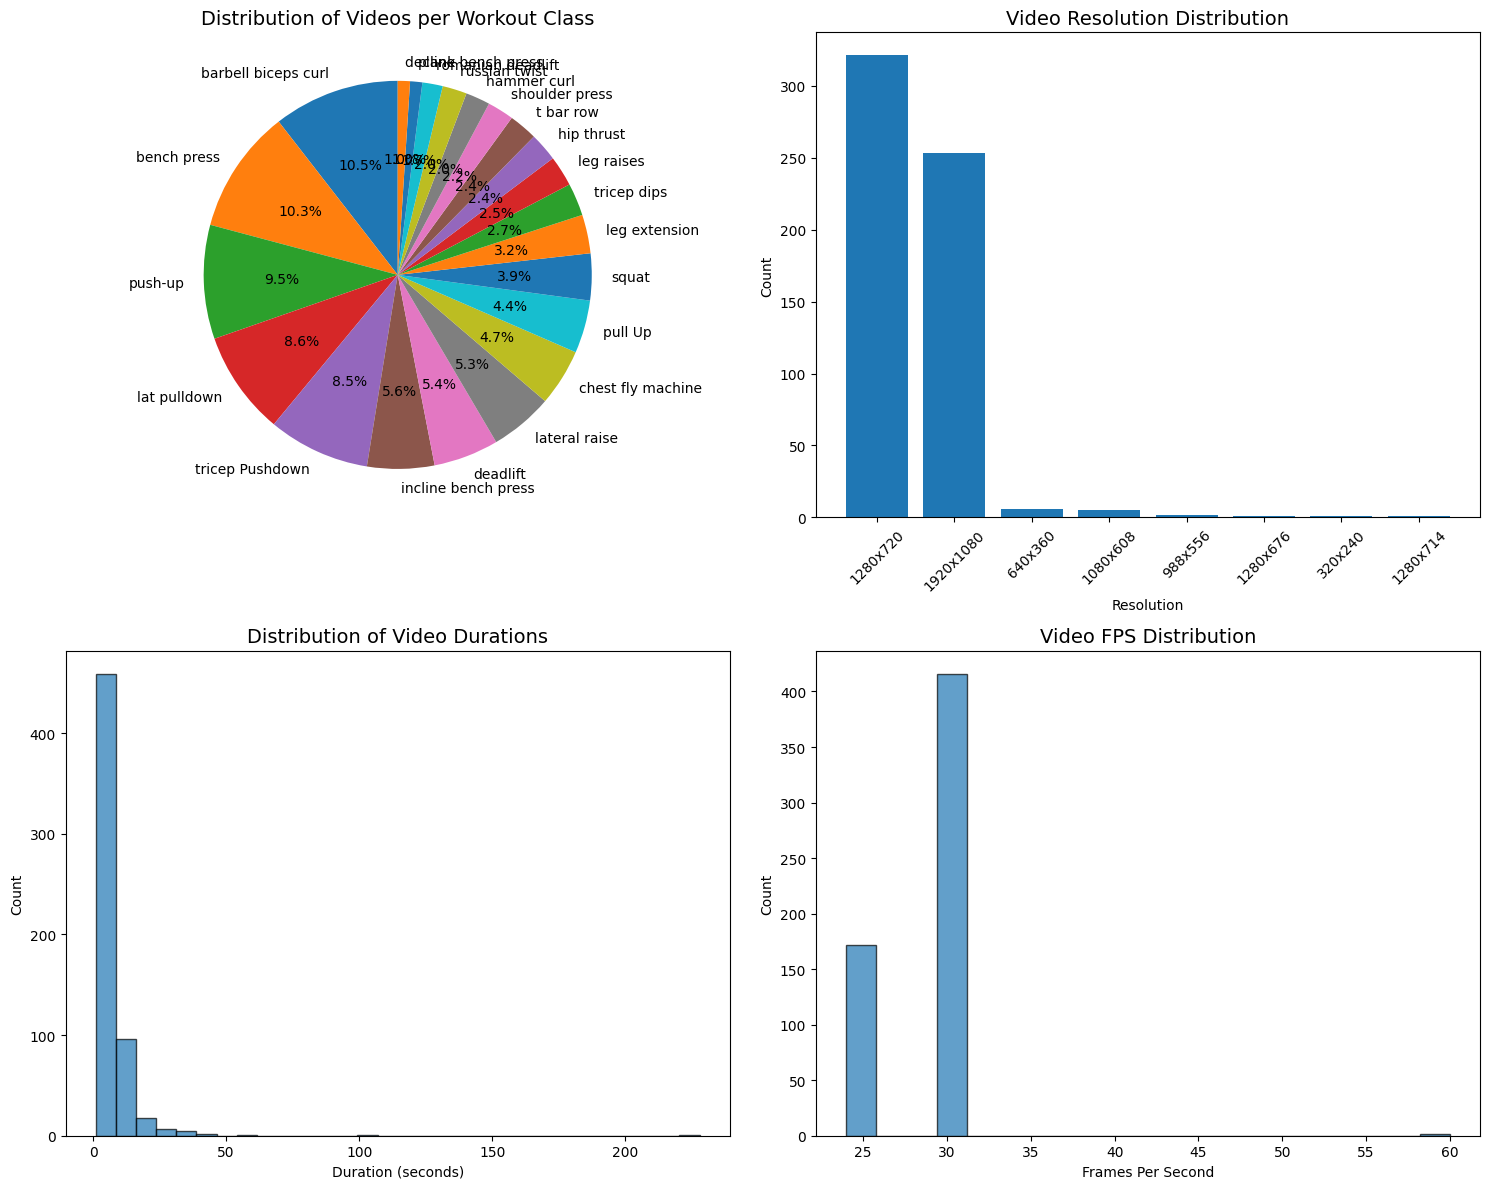


📈 Summary Statistics:
         duration         fps  frame_count  file_size_mb
count  590.000000  590.000000   590.000000    590.000000
mean     6.972840   28.421839   195.996610      3.348434
std     11.747498    3.178634   335.730418      5.402293
min      1.001000   23.976024    30.000000      0.122302
25%      2.769433   25.000000    78.000000      0.407842
50%      4.713042   29.970030   132.500000      1.770178
75%      7.689583   29.970030   210.750000      4.216635
max    228.000000   60.000000  6840.000000     70.629172

🎯 Dataset Insights:
Average video duration: 6.97 seconds
Total dataset size: 1975.58 MB
Most common resolution: 1280x720
Average FPS: 28.42


In [ ]:
# Create visualizations
if 'video_df' in locals() and len(video_df) > 0:
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Pie chart of videos per workout class
    class_counts = video_df['class'].value_counts()
    axes[0, 0].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Distribution of Videos per Workout Class', fontsize=14)

    # 2. Bar chart of video resolution distribution
    resolution_counts = video_df['resolution'].value_counts()
    axes[0, 1].bar(range(len(resolution_counts)), resolution_counts.values)
    axes[0, 1].set_xticks(range(len(resolution_counts)))
    axes[0, 1].set_xticklabels(resolution_counts.index, rotation=45)
    axes[0, 1].set_title('Video Resolution Distribution', fontsize=14)
    axes[0, 1].set_xlabel('Resolution')
    axes[0, 1].set_ylabel('Count')

    # 3. Histogram of video durations
    valid_durations = video_df[video_df['duration'] > 0]['duration']
    if len(valid_durations) > 0:
        axes[1, 0].hist(valid_durations, bins=30, edgecolor='black', alpha=0.7)
        axes[1, 0].set_title('Distribution of Video Durations', fontsize=14)
        axes[1, 0].set_xlabel('Duration (seconds)')
        axes[1, 0].set_ylabel('Count')
    else:
        axes[1, 0].text(0.5, 0.5, 'No duration data available',
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Duration Distribution (No Data)', fontsize=14)

    # 4. FPS distribution
    valid_fps = video_df[video_df['fps'] > 0]['fps']
    if len(valid_fps) > 0:
        axes[1, 1].hist(valid_fps, bins=20, edgecolor='black', alpha=0.7)
        axes[1, 1].set_title('Video FPS Distribution', fontsize=14)
        axes[1, 1].set_xlabel('Frames Per Second')
        axes[1, 1].set_ylabel('Count')
    else:
        axes[1, 1].text(0.5, 0.5, 'No FPS data available',
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('FPS Distribution (No Data)', fontsize=14)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n📈 Summary Statistics:")
    print(video_df.describe())

    # Additional insights
    print(f"\n🎯 Dataset Insights:")
    print(f"Average video duration: {video_df['duration'].mean():.2f} seconds")
    print(f"Total dataset size: {video_df['file_size_mb'].sum():.2f} MB")
    print(f"Most common resolution: {video_df['resolution'].mode().iloc[0] if len(video_df['resolution'].mode()) > 0 else 'Unknown'}")
    print(f"Average FPS: {video_df['fps'].mean():.2f}")

###  Distribution of Videos per Workout Class
- The dataset includes 22 exercise classes.
- The most frequent classes are:
  - **Barbell Biceps Curl** (10.5%)
  - **Bench Press** (10.3%)
  - **Push-Up** (9.5%)
  - **Lat Pulldown** (8.6%)
- Many other exercises (e.g., *Plank*, *Romanian Deadlift*, *Shoulder Press*) are underrepresented (<3%).
-  **Insight**: There is **class imbalance** that can negatively impact training.  
   This will be addressed by using **class weights and focal loss** during model training.

---

###  Video Resolution Distribution
- Majority of videos are in:
  - `1280×720` (HD)
  - `1920×1080` (Full HD)
- A few videos use lower or irregular resolutions such as `640×360`, `320×240`, or higher non-standard sizes.
- 🔎 **Insight**: The dataset is mostly **consistent in resolution**, making preprocessing straightforward.

---

###  Video Duration Distribution
- Most videos are **short**, typically under **20 seconds**.
- Some outliers exceed **200 seconds**.
-  **Insight**: Duration distribution is **right-skewed**.  
   Using fixed-size (e.g., 20-frame) time windows helps normalize input size for the model.

---

###  Video FPS Distribution
- The majority of videos are recorded at:
  - **30 FPS** and **25 FPS**
- A few high-FPS videos exist (e.g., **60 FPS**).
- **Insight**: Frame rate is relatively consistent

---

###  Summary
- **Class imbalance** exists → Mitigated with focal loss and class weighting.
- **Resolution and FPS** → Fairly consistent and suitable for standardized preprocessing.
- **Duration** → Skewed distribution justified fixed-frame sampling (e.g., 20 frames per clip).

This analysis ensures robust and well-informed preprocessing for effective model training.

## POSE ESTIMATION CLASS
### MediaPipe-based pose estimation system for extracting human body landmarks from video frames with confidence filtering and angle calculations.

In [ ]:
def get_video_files(dataset_path):
    video_files = {}

    if not os.path.exists(dataset_path):
        print(f"Dataset path does not exist: {dataset_path}")
        return video_files

    for exercise in EXERCISE_CLASSES:
        exercise_path = os.path.join(dataset_path, exercise)
        if os.path.exists(exercise_path):
            videos = glob.glob(os.path.join(exercise_path, "*.mp4"))
            video_files[exercise] = videos
        else:
            video_files[exercise] = []

    total_videos = sum(len(videos) for videos in video_files.values())
    print(f"Total videos found: {total_videos}")
    return video_files

def extract_features_from_video(video_path, feature_extractor, max_sequences=8, exercise_type=None):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    features_list = []
    frame_features = []
    frame_count = 0
    valid_poses = 0

    while cap.isOpened() and len(features_list) < max_sequences:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % FRAME_SKIP != 0:
            frame_count += 1
            continue

        landmarks, _, confidence = feature_extractor.pose_estimator.extract_landmarks(frame)

        if landmarks is not None and confidence >= MIN_POSE_CONFIDENCE:
            features = feature_extractor.extract_features_from_landmarks(landmarks, exercise_type)
            if features is not None:
                frame_features.append(features)
                valid_poses += 1

        # Create sequence with overlap
        if len(frame_features) >= SEQUENCE_LENGTH:
            sequence = np.array(frame_features[:SEQUENCE_LENGTH])
            features_list.append(sequence)

            # Sliding window with 70% overlap
            overlap = int(SEQUENCE_LENGTH * 0.7)
            frame_features = frame_features[SEQUENCE_LENGTH - overlap:]

        frame_count += 1

    cap.release()

    pose_detection_rate = valid_poses / max(frame_count // FRAME_SKIP, 1)
    if pose_detection_rate < 0.3:
        print(f"Warning: Low pose detection rate ({pose_detection_rate:.2f}) for {os.path.basename(video_path)}")

    return features_list


class PoseEstimator:
    """
    Advanced pose estimation using MediaPipe for biomechanical analysis

    This class handles:
    - Real-time pose detection from video frames
    - Confidence-based filtering
    - Geometric calculations for angles and distances
    """

    def __init__(self):
        """Initialize MediaPipe pose estimation model"""
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            model_complexity=1,
            enable_segmentation=False,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        self.mp_drawing = mp.solutions.drawing_utils

    def extract_landmarks(self, image):
        """
        Extract pose landmarks from an image frame

        Args:
            image: Input image frame from video

        Returns:
            tuple: (landmarks_array, pose_landmarks, average_visibility)
        """
        try:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = self.pose.process(image_rgb)

            if results.pose_landmarks:
                landmarks = []
                visibility_sum = 0
                for landmark in results.pose_landmarks.landmark:
                    landmarks.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
                    visibility_sum += landmark.visibility

                # Filter based on average visibility
                avg_visibility = visibility_sum / 33
                if avg_visibility >= MIN_POSE_CONFIDENCE:
                    return np.array(landmarks), results.pose_landmarks, avg_visibility

            return None, None, 0.0
        except Exception as e:
            return None, None, 0.0

    def calculate_angle(self, a, b, c):
        """
        Calculate angle between three points for biomechanical analysis

        Args:
            a, b, c: Three points where b is the vertex

        Returns:
            float: Angle in degrees
        """
        try:
            a, b, c = np.array(a), np.array(b), np.array(c)
            radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
            angle = np.abs(radians * 180.0 / np.pi)
            return 360 - angle if angle > 180.0 else angle
        except:
            return 0.0

    def calculate_distance(self, point1, point2):
        """
        Calculate Euclidean distance between two points

        Args:
            point1, point2: Two coordinate points

        Returns:
            float: Distance between points
        """
        try:
            return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
        except:
            return 0.0

print("✅ Pose estimation class initialized!")

✅ Pose estimation class initialized!


## POSE ESTIMATION VISUALIZATION
### Visualize MediaPipe pose estimation on sample frames from different exercises to demonstrate the quality of landmark detection.

👁️ POSE ESTIMATION VISUALIZATION
Total videos found: 590

🎯 Processing: tricep Pushdown
📁 Video: tricep pushdown_17.mp4
✅ Pose detected with confidence: 0.693
📊 Frame 20/74

🎯 Processing: deadlift
📁 Video: deadlift_1.mp4
✅ Pose detected with confidence: 0.691
📊 Frame 105/150


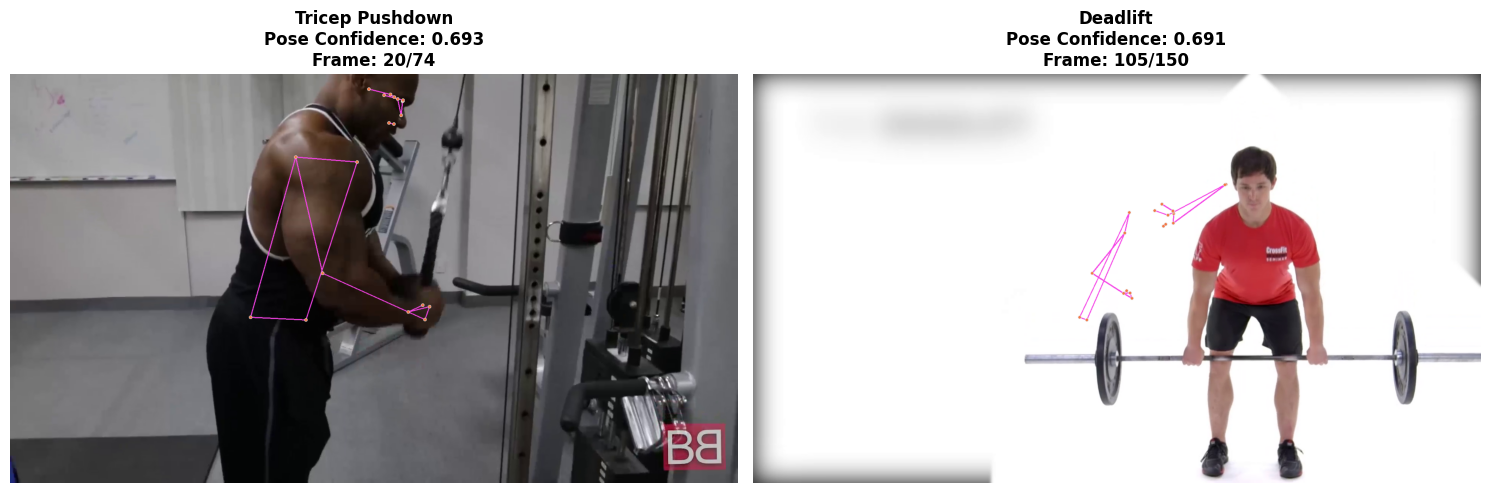


📋 Pose Estimation Summary:
   🎯 MediaPipe model complexity: 1
   📊 Detection confidence threshold: 0.6
   🔍 Landmark points tracked: 33
   📐 Features extracted per frame: 83


In [ ]:
def visualize_pose_estimation():
    """
    Display pose estimation results on random frames with guaranteed pose detection
    """
    print("👁️ POSE ESTIMATION VISUALIZATION")
    print("="*50)

    # Get video files
    video_files = get_video_files(DATASET_PATH)
    pose_estimator = PoseEstimator()

    # Available exercises
    available_exercises = [exercise for exercise in EXERCISE_CLASSES
                          if exercise in video_files and video_files[exercise]]

    if len(available_exercises) < 2:
        print("❌ Not enough exercise videos found")
        return

    demo_exercises = []
    selected_exercises = random.sample(available_exercises, 2)

    # Find frames with pose detection for each exercise
    for exercise in selected_exercises:
        max_attempts = 10
        found_pose = False

        for attempt in range(max_attempts):
            random_video = random.choice(video_files[exercise])

            cap = cv2.VideoCapture(random_video)
            if not cap.isOpened():
                continue

            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            start_frame = int(total_frames * 0.2)
            end_frame = int(total_frames * 0.8)

            # Try multiple random frames
            for _ in range(5):
                random_frame = random.randint(start_frame, end_frame)
                cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)
                ret, frame = cap.read()

                if ret:
                    landmarks, pose_landmarks, confidence = pose_estimator.extract_landmarks(frame)
                    if pose_landmarks is not None and confidence >= MIN_POSE_CONFIDENCE:
                        demo_exercises.append((exercise, random_video, frame, random_frame, total_frames, confidence, pose_landmarks))
                        found_pose = True
                        break

            cap.release()
            if found_pose:
                break

        if not found_pose:
            print(f"⚠️ Could not find good pose detection for {exercise}")

    if len(demo_exercises) < 2:
        print("❌ Could not find 2 exercises with good pose detection")
        return

    fig, axes = plt.subplots(1, 2, figsize=(15, 8))

    for idx, (exercise_name, video_path, frame, frame_num, total_frames, confidence, pose_landmarks) in enumerate(demo_exercises):
        print(f"\n🎯 Processing: {exercise_name}")
        print(f"📁 Video: {os.path.basename(video_path)}")

        # Convert frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Draw pose landmarks
        mp.solutions.drawing_utils.draw_landmarks(
            frame_rgb,
            pose_landmarks,
            mp.solutions.pose.POSE_CONNECTIONS,
            mp.solutions.drawing_utils.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
            mp.solutions.drawing_utils.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1)
        )

        # Display in subplot
        axes[idx].imshow(frame_rgb)
        axes[idx].set_title(f'{exercise_name.title()}\nPose Confidence: {confidence:.3f}\nFrame: {frame_num}/{total_frames}',
                           fontsize=12, fontweight='bold')
        axes[idx].axis('off')

        print(f"✅ Pose detected with confidence: {confidence:.3f}")
        print(f"📊 Frame {frame_num}/{total_frames}")

    plt.tight_layout()
    plt.show()

    print(f"\n📋 Pose Estimation Summary:")
    print(f"   🎯 MediaPipe model complexity: 1")
    print(f"   📊 Detection confidence threshold: {MIN_POSE_CONFIDENCE}")
    print(f"   🔍 Landmark points tracked: 33")
    print(f"   📐 Features extracted per frame: 83")

# Run pose estimation visualization
visualize_pose_estimation()

I've noticed a couple of issues with the video frames that could negatively impact my exercise classification training:

- Incomplete Body Coverage: Some frames cut off parts of the body, meaning the model isn't seeing the full skeleton and even the exercise essential movements. This issue is demonstrated in the left image.

- The Mediapipe fails to detect the trainer's body due to challenging  background and environment

- Presence of Other Individuals: Other people occasionally appear in the video, which can distract the model and lead to misclassifications.This issue is demonstrated in the right image.

These inconsistencies can harm the training process by introducing noise and incomplete information, ultimately affecting the model's ability to accurately classify exercises.

## FEATURE EXTRACTION CLASS
### Advanced feature extraction system that converts pose landmarks into biomechanically-informed features for exercise classification.

In [ ]:
class FeatureExtractor:
    """
    Extract exercise-specific biomechanical features from pose landmarks

    Features include:
    - Normalized body coordinates
    - Joint angles specific to exercise types
    - Distance measurements
    - Velocity tracking between frames
    """

    def __init__(self):
        """Initialize feature extractor with pose estimator"""
        self.pose_estimator = PoseEstimator()
        self.prev_landmarks = None

    def extract_features_from_landmarks(self, landmarks, exercise_type=None):
        """
        Extract comprehensive biomechanical features from pose landmarks

        Args:
            landmarks: Raw landmark data from MediaPipe
            exercise_type: Specific exercise for targeted feature extraction

        Returns:
            numpy.array: 83-dimensional feature vector
        """
        if landmarks is None or len(landmarks) != 132:
            return None

        landmarks_reshaped = landmarks.reshape(-1, 4)
        features = []

        # MediaPipe landmark indices
        LEFT_SHOULDER, RIGHT_SHOULDER = 11, 12
        LEFT_ELBOW, RIGHT_ELBOW = 13, 14
        LEFT_WRIST, RIGHT_WRIST = 15, 16
        LEFT_HIP, RIGHT_HIP = 23, 24
        LEFT_KNEE, RIGHT_KNEE = 25, 26
        LEFT_ANKLE, RIGHT_ANKLE = 27, 28
        NOSE = 0
        LEFT_HEEL, RIGHT_HEEL = 29, 30
        LEFT_FOOT_INDEX, RIGHT_FOOT_INDEX = 31, 32

        try:
            # Normalized coordinates (relative to hip center for scale invariance)
            hip_center = [(landmarks_reshaped[LEFT_HIP][0] + landmarks_reshaped[RIGHT_HIP][0]) / 2,
                         (landmarks_reshaped[LEFT_HIP][1] + landmarks_reshaped[RIGHT_HIP][1]) / 2]

            # Key points relative to hip center
            key_indices = [NOSE, LEFT_SHOULDER, RIGHT_SHOULDER, LEFT_ELBOW, RIGHT_ELBOW,
                          LEFT_WRIST, RIGHT_WRIST, LEFT_KNEE, RIGHT_KNEE, LEFT_ANKLE, RIGHT_ANKLE]

            for idx in key_indices:
                rel_x = landmarks_reshaped[idx][0] - hip_center[0]
                rel_y = landmarks_reshaped[idx][1] - hip_center[1]
                features.extend([rel_x, rel_y, landmarks_reshaped[idx][2]])

            # Exercise-specific biomechanical angle calculations
            angles = self._calculate_exercise_specific_angles(landmarks_reshaped, exercise_type)
            features.extend(angles)

            # Biomechanical distance measurements
            distances = [
                # Basic body segment distances
                self.pose_estimator.calculate_distance(landmarks_reshaped[LEFT_WRIST][:2],
                                                     landmarks_reshaped[RIGHT_WRIST][:2]),
                self.pose_estimator.calculate_distance(landmarks_reshaped[LEFT_ANKLE][:2],
                                                     landmarks_reshaped[RIGHT_ANKLE][:2]),
               self.pose_estimator.calculate_distance(landmarks_reshaped[LEFT_SHOULDER][:2],
                                                     landmarks_reshaped[RIGHT_SHOULDER][:2]),
                # Upper body reach and extension
                self.pose_estimator.calculate_distance(landmarks_reshaped[LEFT_SHOULDER][:2],
                                                     landmarks_reshaped[LEFT_WRIST][:2]),
                self.pose_estimator.calculate_distance(landmarks_reshaped[RIGHT_SHOULDER][:2],
                                                     landmarks_reshaped[RIGHT_WRIST][:2]),
                # Lower body length measurements
                self.pose_estimator.calculate_distance(landmarks_reshaped[LEFT_HIP][:2],
                                                     landmarks_reshaped[LEFT_ANKLE][:2]),
                self.pose_estimator.calculate_distance(landmarks_reshaped[RIGHT_HIP][:2],
                                                     landmarks_reshaped[RIGHT_ANKLE][:2])
            ]
            features.extend(distances)

            # Velocity features for movement dynamics
            if self.prev_landmarks is not None:
                prev_reshaped = self.prev_landmarks.reshape(-1, 4)
                velocities = []
                for idx in key_indices[:7]:  # Upper body + core movement
                    vel_x = landmarks_reshaped[idx][0] - prev_reshaped[idx][0]
                    vel_y = landmarks_reshaped[idx][1] - prev_reshaped[idx][1]
                    velocities.extend([vel_x, vel_y])
                features.extend(velocities)
            else:
                features.extend([0.0] * 14)  # Zero velocities for first frame

            self.prev_landmarks = landmarks

        except Exception as e:
            print(f"Feature extraction error: {e}")
            features = [0.0] * 83  # Reset to all zeros if error

        # Ensure exactly 83 features every time
        if len(features) < 83:
            features.extend([0.0] * (83 - len(features)))
        elif len(features) > 83:
            features = features[:83]

        return np.array(features)

    def _calculate_exercise_specific_angles(self, landmarks_reshaped, exercise_type):
        """
        Calculate biomechanical angles with exercise-specific discrimination

        Args:
            landmarks_reshaped: Reshaped landmark coordinates
            exercise_type: Type of exercise for specific angle calculations

        Returns:
            list: 21 biomechanical angles for exercise discrimination
        """
        # Landmark indices
        LEFT_SHOULDER, RIGHT_SHOULDER = 11, 12
        LEFT_ELBOW, RIGHT_ELBOW = 13, 14
        LEFT_WRIST, RIGHT_WRIST = 15, 16
        LEFT_HIP, RIGHT_HIP = 23, 24
        LEFT_KNEE, RIGHT_KNEE = 25, 26
        LEFT_ANKLE, RIGHT_ANKLE = 27, 28
        NOSE = 0

        angles = []

        # Core biomechanical angles (always calculated)

        # 1. Elbow angles (critical for all arm exercises)
        left_elbow_angle = self.pose_estimator.calculate_angle(
            landmarks_reshaped[LEFT_SHOULDER][:2],
            landmarks_reshaped[LEFT_ELBOW][:2],
            landmarks_reshaped[LEFT_WRIST][:2]
        )
        right_elbow_angle = self.pose_estimator.calculate_angle(
            landmarks_reshaped[RIGHT_SHOULDER][:2],
            landmarks_reshaped[RIGHT_ELBOW][:2],
            landmarks_reshaped[RIGHT_WRIST][:2]
        )
        angles.extend([left_elbow_angle, right_elbow_angle])

        # 2. Knee angles (critical for all leg exercises)
        left_knee_angle = self.pose_estimator.calculate_angle(
            landmarks_reshaped[LEFT_HIP][:2],
            landmarks_reshaped[LEFT_KNEE][:2],
            landmarks_reshaped[LEFT_ANKLE][:2]
        )
        right_knee_angle = self.pose_estimator.calculate_angle(
            landmarks_reshaped[RIGHT_HIP][:2],
            landmarks_reshaped[RIGHT_KNEE][:2],
            landmarks_reshaped[RIGHT_ANKLE][:2]
        )
        angles.extend([left_knee_angle, right_knee_angle])

        # 3. Hip angles (critical for squats, deadlifts, hip thrusts)
        left_hip_angle = self.pose_estimator.calculate_angle(
            landmarks_reshaped[LEFT_SHOULDER][:2],
            landmarks_reshaped[LEFT_HIP][:2],
            landmarks_reshaped[LEFT_KNEE][:2]
        )
        right_hip_angle = self.pose_estimator.calculate_angle(
            landmarks_reshaped[RIGHT_SHOULDER][:2],
            landmarks_reshaped[RIGHT_HIP][:2],
            landmarks_reshaped[RIGHT_KNEE][:2]
        )
        angles.extend([left_hip_angle, right_hip_angle])

        # 4. Shoulder elevation angles
        left_shoulder_elevation = self.pose_estimator.calculate_angle(
            landmarks_reshaped[LEFT_HIP][:2],
            landmarks_reshaped[LEFT_SHOULDER][:2],
            landmarks_reshaped[LEFT_ELBOW][:2]
        )
        right_shoulder_elevation = self.pose_estimator.calculate_angle(
            landmarks_reshaped[RIGHT_HIP][:2],
            landmarks_reshaped[RIGHT_SHOULDER][:2],
            landmarks_reshaped[RIGHT_ELBOW][:2]
        )
        angles.extend([left_shoulder_elevation, right_shoulder_elevation])

        # 5. Spine/Torso angle (critical for posture)
        spine_angle = self.pose_estimator.calculate_angle(
            [(landmarks_reshaped[LEFT_HIP][0] + landmarks_reshaped[RIGHT_HIP][0]) / 2,
             (landmarks_reshaped[LEFT_HIP][1] + landmarks_reshaped[RIGHT_HIP][1]) / 2],
            [(landmarks_reshaped[LEFT_SHOULDER][0] + landmarks_reshaped[RIGHT_SHOULDER][0]) / 2,
             (landmarks_reshaped[LEFT_SHOULDER][1] + landmarks_reshaped[RIGHT_SHOULDER][1]) / 2],
            [landmarks_reshaped[NOSE][0], landmarks_reshaped[NOSE][1]]
        )
        angles.append(spine_angle)

        # Exercise-specific discrimination angles
        if exercise_type:
            specific_angles = EXERCISE_SPECIFIC_ANGLES.get(exercise_type, [])

            # Chest exercise discrimination
            if exercise_type in ['bench press', 'chest fly machine', 'decline bench press', 'incline bench press']:
                arm_convergence = self.pose_estimator.calculate_angle(
                    landmarks_reshaped[LEFT_WRIST][:2],
                    [(landmarks_reshaped[LEFT_SHOULDER][0] + landmarks_reshaped[RIGHT_SHOULDER][0]) / 2,
                     (landmarks_reshaped[LEFT_SHOULDER][1] + landmarks_reshaped[RIGHT_SHOULDER][1]) / 2],
                    landmarks_reshaped[RIGHT_WRIST][:2]
                )
                torso_incline = self.pose_estimator.calculate_angle(
                    [(landmarks_reshaped[LEFT_HIP][0] + landmarks_reshaped[RIGHT_HIP][0]) / 2,
                     (landmarks_reshaped[LEFT_HIP][1] + landmarks_reshaped[RIGHT_HIP][1]) / 2],
                    [(landmarks_reshaped[LEFT_SHOULDER][0] + landmarks_reshaped[RIGHT_SHOULDER][0]) / 2,
                     (landmarks_reshaped[LEFT_SHOULDER][1] + landmarks_reshaped[RIGHT_SHOULDER][1]) / 2],
                    [landmarks_reshaped[NOSE][0], landmarks_reshaped[NOSE][1] - 0.1]
                )
                angles.extend([arm_convergence, torso_incline])
            else:
                angles.extend([0.0, 0.0])

            # Deadlift discrimination
            if exercise_type in ['deadlift', 'romanian deadlift']:
                avg_knee_bend = (left_knee_angle + right_knee_angle) / 2
                hip_dominance = self.pose_estimator.calculate_angle(
                    [(landmarks_reshaped[LEFT_KNEE][0] + landmarks_reshaped[RIGHT_KNEE][0]) / 2,
                     (landmarks_reshaped[LEFT_KNEE][1] + landmarks_reshaped[RIGHT_KNEE][1]) / 2],
                    [(landmarks_reshaped[LEFT_HIP][0] + landmarks_reshaped[RIGHT_HIP][0]) / 2,
                     (landmarks_reshaped[LEFT_HIP][1] + landmarks_reshaped[RIGHT_HIP][1]) / 2],
                    [landmarks_reshaped[NOSE][0], landmarks_reshaped[NOSE][1]]
                )
                angles.extend([avg_knee_bend, hip_dominance])
            else:
                angles.extend([0.0, 0.0])

            # Standing vs ground exercise discrimination
            if exercise_type in ['hammer curl', 'barbell biceps curl', 'lateral raise', 'shoulder press']:
                standing_posture = abs(
                    ((landmarks_reshaped[LEFT_SHOULDER][0] + landmarks_reshaped[RIGHT_SHOULDER][0]) / 2) -
                    ((landmarks_reshaped[LEFT_HIP][0] + landmarks_reshaped[RIGHT_HIP][0]) / 2)
                )
                arm_position = self.pose_estimator.calculate_distance(
                    landmarks_reshaped[LEFT_WRIST][:2],
                    [(landmarks_reshaped[LEFT_HIP][0] + landmarks_reshaped[RIGHT_HIP][0]) / 2,
                     (landmarks_reshaped[LEFT_HIP][1] + landmarks_reshaped[RIGHT_HIP][1]) / 2]
                )
                angles.extend([standing_posture, arm_position])
            elif exercise_type in ['plank', 'push-up']:
                body_parallel = abs(
                    landmarks_reshaped[NOSE][1] -
                    ((landmarks_reshaped[LEFT_HIP][1] + landmarks_reshaped[RIGHT_HIP][1]) / 2)
                )
                support_width = self.pose_estimator.calculate_distance(
                    landmarks_reshaped[LEFT_WRIST][:2],
                    landmarks_reshaped[RIGHT_WRIST][:2]
                )
                angles.extend([body_parallel, support_width])
            else:
                angles.extend([0.0, 0.0])

            # Curl discrimination
            if exercise_type in ['hammer curl', 'barbell biceps curl']:
                wrist_alignment = self.pose_estimator.calculate_angle(
                    landmarks_reshaped[LEFT_ELBOW][:2],
                    landmarks_reshaped[LEFT_WRIST][:2],
                    [landmarks_reshaped[LEFT_WRIST][0] + 0.1, landmarks_reshaped[LEFT_WRIST][1]]
                )
                hand_separation = self.pose_estimator.calculate_distance(
                    landmarks_reshaped[LEFT_WRIST][:2],
                    landmarks_reshaped[RIGHT_WRIST][:2]
                )
                angles.extend([wrist_alignment, hand_separation])
            else:
                angles.extend([0.0, 0.0])

            # Additional exercise-specific angles
            if 'shoulder_horizontal' in specific_angles:
                shoulder_horizontal = self.pose_estimator.calculate_angle(
                    landmarks_reshaped[LEFT_SHOULDER][:2],
                    landmarks_reshaped[RIGHT_SHOULDER][:2],
                    landmarks_reshaped[LEFT_WRIST][:2]
                )
                angles.append(shoulder_horizontal)
            else:
                angles.append(0.0)

            if 'ankle_angles' in specific_angles:
                left_ankle_angle = self.pose_estimator.calculate_angle(
                    landmarks_reshaped[LEFT_KNEE][:2],
                    landmarks_reshaped[LEFT_ANKLE][:2],
                    [landmarks_reshaped[LEFT_ANKLE][0] + 0.1, landmarks_reshaped[LEFT_ANKLE][1]]
                )
                right_ankle_angle = self.pose_estimator.calculate_angle(
                    landmarks_reshaped[RIGHT_KNEE][:2],
                    landmarks_reshaped[RIGHT_ANKLE][:2],
                    [landmarks_reshaped[RIGHT_ANKLE][0] + 0.1, landmarks_reshaped[RIGHT_ANKLE][1]]
                )
                angles.extend([left_ankle_angle, right_ankle_angle])
            else:
                angles.extend([0.0, 0.0])

            if 'hip_hinge' in specific_angles:
                hip_hinge = self.pose_estimator.calculate_angle(
                    [(landmarks_reshaped[LEFT_KNEE][0] + landmarks_reshaped[RIGHT_KNEE][0]) / 2,
                    (landmarks_reshaped[LEFT_KNEE][1] + landmarks_reshaped[RIGHT_KNEE][1]) / 2],
                    [(landmarks_reshaped[LEFT_HIP][0] + landmarks_reshaped[RIGHT_HIP][0]) / 2,
                     (landmarks_reshaped[LEFT_HIP][1] + landmarks_reshaped[RIGHT_HIP][1]) / 2],
                    [(landmarks_reshaped[LEFT_SHOULDER][0] + landmarks_reshaped[RIGHT_SHOULDER][0]) / 2,
                     (landmarks_reshaped[LEFT_SHOULDER][1] + landmarks_reshaped[RIGHT_SHOULDER][1]) / 2]
                )
                angles.append(hip_hinge)
            else:
                angles.append(0.0)

            if 'shoulder_abduction' in specific_angles:
                left_abduction = self.pose_estimator.calculate_angle(
                    landmarks_reshaped[LEFT_HIP][:2],
                    landmarks_reshaped[LEFT_SHOULDER][:2],
                    landmarks_reshaped[LEFT_WRIST][:2]
                )
                right_abduction = self.pose_estimator.calculate_angle(
                    landmarks_reshaped[RIGHT_HIP][:2],
                    landmarks_reshaped[RIGHT_SHOULDER][:2],
                    landmarks_reshaped[RIGHT_WRIST][:2]
                )
                angles.extend([left_abduction, right_abduction])
            else:
                angles.extend([0.0, 0.0])
        else:
            # If no exercise type specified, pad with zeros
            angles.extend([0.0] * 12)

        return angles  # Total: 9 core + 12 exercise-specific = 21 angles

print("✅ Feature extraction class initialized!")

✅ Feature extraction class initialized!


## DATA AUGMENTATION FUNCTIONS
### Data augmentation techniques to increase dataset diversity and improve model generalization through temporal and spatial transformations.

In [ ]:
def augment_sequence(sequence, augment_prob=0.3):
    """
    Apply data augmentation techniques to exercise sequences

    Args:
        sequence: Input sequence of pose features
        augment_prob: Probability of applying each augmentation

    Returns:
        list: Original and augmented sequences
    """
    augmented = [sequence]  # Original sequence

    if random.random() < augment_prob:
        # Time stretching - simulate different exercise speeds
        stretch_factor = random.uniform(0.8, 1.2)
        if stretch_factor != 1.0:
            new_length = int(len(sequence) * stretch_factor)
            if new_length >= SEQUENCE_LENGTH:
                indices = np.linspace(0, len(sequence)-1, new_length).astype(int)
                stretched = sequence[indices][:SEQUENCE_LENGTH]
                augmented.append(stretched)

    if random.random() < augment_prob:
        # Noise injection - simulate sensor noise and variations
        noise = np.random.normal(0, 0.01, sequence.shape)
        noisy = sequence + noise
        augmented.append(noisy)

    if random.random() < augment_prob:
        # Temporal shift - simulate different starting points
        shift = random.randint(-2, 2)
        if shift != 0:
            shifted = np.roll(sequence, shift, axis=0)
            augmented.append(shifted)

    return augmented

print("✅ Data augmentation functions ready!")

✅ Data augmentation functions ready!



## FOCAL LOSS IMPLEMENTATION
### Focal Loss implementation for handling class imbalance in the dataset.This loss function focuses learning on hard examples and reduces the weight of well-classified examples.


In [ ]:
def focal_loss(alpha=1.0, gamma=2.0):
    """
    Focal Loss implementation for imbalanced classification

    Args:
        alpha: Weighting factor for rare class
        gamma: Focusing parameter for hard examples

    Returns:
        function: Focal loss function for Keras
    """
    def focal_loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Convert sparse labels to one-hot
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])

        # Calculate cross entropy
        ce = -y_true_one_hot * tf.math.log(y_pred)

        # Calculate focal weight
        p_t = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1, keepdims=True)
        alpha_t = alpha * y_true_one_hot
        focal_weight = alpha_t * tf.pow((1 - p_t), gamma)

        # Apply focal weight
        fl = focal_weight * ce

        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return focal_loss_fn

print("✅ Focal loss implementation ready!")

✅ Focal loss implementation ready!



## VIDEO PROCESSING FUNCTIONS
### Video processing pipeline for extracting pose features from workout videos with intelligent sampling and quality filtering.


In [ ]:

def extract_features_from_video(video_path, feature_extractor, max_sequences=8, exercise_type=None):
    """
    Extract pose features from a single video file

    Args:
        video_path: Path to the video file
        feature_extractor: FeatureExtractor instance
        max_sequences: Maximum number of sequences to extract
        exercise_type: Type of exercise for specific feature extraction

    Returns:
        list: List of feature sequences extracted from the video
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    features_list = []
    frame_features = []
    frame_count = 0
    valid_poses = 0

    while cap.isOpened() and len(features_list) < max_sequences:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % FRAME_SKIP != 0:
            frame_count += 1
            continue

        landmarks, _, confidence = feature_extractor.pose_estimator.extract_landmarks(frame)

        if landmarks is not None and confidence >= MIN_POSE_CONFIDENCE:
            features = feature_extractor.extract_features_from_landmarks(landmarks, exercise_type)
            if features is not None:
                frame_features.append(features)
                valid_poses += 1

        # Create sequence with sliding window
        if len(frame_features) >= SEQUENCE_LENGTH:
            sequence = np.array(frame_features[:SEQUENCE_LENGTH])
            features_list.append(sequence)

            # Sliding window with 70% overlap for more training data
            overlap = int(SEQUENCE_LENGTH * 0.7)
            frame_features = frame_features[SEQUENCE_LENGTH - overlap:]

        frame_count += 1

    cap.release()

    pose_detection_rate = valid_poses / max(frame_count // FRAME_SKIP, 1)
    if pose_detection_rate < 0.3:
        print(f"Warning: Low pose detection rate ({pose_detection_rate:.2f}) for {os.path.basename(video_path)}")

    return features_list

def load_dataset_optimized(dataset_path, max_videos_per_class=20, max_sequences_per_video=5):
    """
    Load dataset with proper video-level splitting to prevent data leakage
    """
    print("🔄 Loading dataset with video-level splits...")

    # Create video-level splits first
    video_splits = create_video_level_splits(dataset_path)

    # Initialize feature extractor
    feature_extractor = FeatureExtractor()

    # Load sequences for each split separately
    X_train, y_train, train_info = load_sequences_by_split(
        video_splits, feature_extractor, 'train', max_sequences_per_video
    )
    X_val, y_val, val_info = load_sequences_by_split(
        video_splits, feature_extractor, 'val', max_sequences_per_video
    )
    X_test, y_test, test_info = load_sequences_by_split(
        video_splits, feature_extractor, 'test', max_sequences_per_video
    )

    print(f"📊 Split Summary:")
    print(f"  Training: {len(X_train)} sequences from {len(train_info)} videos")
    print(f"  Validation: {len(X_val)} sequences from {len(val_info)} videos")
    print(f"  Test: {len(X_test)} sequences from {len(test_info)} videos")

    # Store split information for later use
    global video_split_info
    video_split_info = {
        'splits': video_splits,
        'train_info': train_info,
        'val_info': val_info,
        'test_info': test_info,
        'X_test': X_test,
        'y_test': y_test
    }

    # Return training and validation data (test held out)
    return np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val])

def create_video_level_splits(dataset_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """Create proper video-level data splits"""
    random.seed(random_state)
    np.random.seed(random_state)

    video_splits = {}

    for exercise in EXERCISE_CLASSES:
        exercise_path = os.path.join(dataset_path, exercise)
        if not os.path.exists(exercise_path):
            continue

        video_files = [f for f in os.listdir(exercise_path) if f.endswith('.mp4')]

        if len(video_files) < 3:
            print(f"⚠️ {exercise}: only {len(video_files)} videos")

        random.shuffle(video_files)

        n_videos = len(video_files)
        train_end = int(n_videos * train_ratio)
        val_end = train_end + int(n_videos * val_ratio)

        train_videos = video_files[:max(1, train_end)]
        val_videos = video_files[train_end:max(train_end + 1, val_end)]
        test_videos = video_files[val_end:]

        # Ensure at least 1 video per split if possible
        if len(test_videos) == 0 and len(val_videos) > 1:
            test_videos = [val_videos.pop()]
        if len(val_videos) == 0 and len(train_videos) > 1:
            val_videos = [train_videos.pop()]

        video_splits[exercise] = {
            'train': [os.path.join(exercise_path, v) for v in train_videos],
            'val': [os.path.join(exercise_path, v) for v in val_videos],
            'test': [os.path.join(exercise_path, v) for v in test_videos]
        }

    return video_splits

def load_sequences_by_split(video_splits, feature_extractor, split_type, max_sequences_per_video):
    """Load sequences from videos for a specific split"""
    all_sequences = []
    all_labels = []
    video_info = []

    for exercise, splits in video_splits.items():
        videos = splits.get(split_type, [])

        for video_path in videos:
            try:
                sequences = extract_features_from_video(
                    video_path, feature_extractor, max_sequences_per_video, exercise_type=exercise
                )

                video_info.append({
                    'video_path': video_path,
                    'exercise': exercise,
                    'split': split_type,
                    'sequences_extracted': len(sequences)
                })

                for sequence in sequences:
                    all_sequences.append(sequence)
                    all_labels.append(exercise)

            except Exception as e:
                print(f"❌ Error processing {video_path}: {e}")
                continue

    return np.array(all_sequences), np.array(all_labels), video_info

print("✅ Video processing functions ready!")


✅ Video processing functions ready!



## ATTENTION-BASED MODEL ARCHITECTURE
### Deep learning model with bidirectional LSTM and multi-head attention for temporal pattern recognition in exercise sequences.

In [ ]:


def create_attention_model(input_shape, num_classes):
    """
    Create attention-based neural network for exercise classification

    Args:
        input_shape: Shape of input sequences (timesteps, features)
        num_classes: Number of exercise classes

    Returns:
        keras.Model: Compiled neural network model
    """
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM layers for temporal modeling
    lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(inputs)
    lstm1 = LayerNormalization()(lstm1)

    lstm2 = Bidirectional(LSTM(32, return_sequences=True, dropout=0.2))(lstm1)
    lstm2 = LayerNormalization()(lstm2)

    # Multi-head attention mechanism
    attention = MultiHeadAttention(num_heads=4, key_dim=32)(lstm2, lstm2)
    attention = LayerNormalization()(attention)

    # Global pooling for sequence-level features
    avg_pool = GlobalAveragePooling1D()(attention)
    max_pool = GlobalMaxPooling1D()(attention)

    # Combine pooled features
    combined = Concatenate()([avg_pool, max_pool])
    combined = BatchNormalization()(combined)

    # Classification head
    dense1 = Dense(64, activation='relu')(combined)
    dense1 = Dropout(0.3)(dense1)
    dense1 = BatchNormalization()(dense1)

    dense2 = Dense(32, activation='relu')(dense1)
    dense2 = Dropout(0.2)(dense2)

    outputs = Dense(num_classes, activation='softmax')(dense2)

    model = Model(inputs, outputs)
    return model

print("✅ Model architecture defined!")




✅ Model architecture defined!


## TRAINING PIPELINE
### Complete training pipeline with data loading, preprocessing, model training, and evaluation with comprehensive metrics and visualizations.

In [ ]:

def train_classifier():
    """Train with proper video-level splits"""
    print("Starting training pipeline with video splits...")

    # Load dataset (now returns combined train+val, test held separately)
    X_combined, y_combined = load_dataset_optimized(DATASET_PATH, max_videos_per_class=20, max_sequences_per_video=6)

    if len(X_combined) == 0:
        print("No data loaded!")
        return None, None, None, None

    # Get the actual train/val split from stored info
    global video_split_info
    X_train_raw, y_train_raw, _ = load_sequences_by_split(
        video_split_info['splits'], FeatureExtractor(), 'train', 6
    )
    X_val_raw, y_val_raw, _ = load_sequences_by_split(
        video_split_info['splits'], FeatureExtractor(), 'val', 6
    )

    print(f"Proper splits - Train: {len(X_train_raw)}, Val: {len(X_val_raw)}")

    # Encode labels
    label_encoder = LabelEncoder()

    # Fit on all available labels for consistency
    all_labels = np.concatenate([y_train_raw, y_val_raw, video_split_info['y_test']])
    label_encoder.fit(all_labels)

    y_train = label_encoder.transform(y_train_raw)
    y_val = label_encoder.transform(y_val_raw)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))

    # Feature scaling - fit only on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, X_train_raw.shape[-1])).reshape(X_train_raw.shape)
    X_val_scaled = scaler.transform(X_val_raw.reshape(-1, X_val_raw.shape[-1])).reshape(X_val_raw.shape)

    # Create model
    input_shape = (X_train_raw.shape[1], X_train_raw.shape[2])
    num_classes = len(np.unique(y_train))

    model = create_attention_model(input_shape, num_classes)

    # Use focal loss as before
    try:
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=focal_loss(alpha=1.0, gamma=2.0),
            metrics=['accuracy']
        )
        print("Using focal loss")
    except:
        print("Focal loss failed, using sparse categorical crossentropy")
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    print("\nModel Architecture:")
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
        ModelCheckpoint('best_model_video_split.keras', save_best_only=True, monitor='val_accuracy'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)
    ]

    # Train with proper validation split
    print("Training with video-level splits...")
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),  # True validation set
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
    print(f"\nValidation Accuracy: {val_accuracy:.4f}")

    # Final test on held-out test set
    if len(video_split_info['X_test']) > 0:
        X_test_scaled = scaler.transform(
            video_split_info['X_test'].reshape(-1, video_split_info['X_test'].shape[-1])
        ).reshape(video_split_info['X_test'].shape)

        y_test_encoded = label_encoder.transform(video_split_info['y_test'])

        test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
        print(f"Final Test Accuracy: {test_accuracy:.4f}")

        y_pred = model.predict(X_test_scaled, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        print("\nTest Set Classification Report:")
        print("="*60)
        print(classification_report(y_test_encoded, y_pred_classes,
                                  target_names=label_encoder.classes_,
                                  zero_division=0))

        return model, label_encoder, scaler, history, X_test_scaled, y_test_encoded, y_pred_classes
    else:
        # Return validation results if no test set
        y_pred = model.predict(X_val_scaled, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        return model, label_encoder, scaler, history, X_val_scaled, y_val, y_pred_classes

def full_zero_performance_investigation():
    """
    Complete investigation of zero-performance classes
    """
    print("🔍 ZERO PERFORMANCE CLASSES ANALYSIS")
    print("="*50)

    # Check the actual data distribution
    if 'video_split_info' in globals():
        splits = video_split_info['splits']

        zero_classes = ['decline bench press', 'romanian deadlift']

        for exercise in zero_classes:
            print(f"\n📊 {exercise.upper()}:")

            if exercise in splits:
                train_videos = len(splits[exercise]['train'])
                val_videos = len(splits[exercise]['val'])
                test_videos = len(splits[exercise]['test'])
                total_videos = train_videos + val_videos + test_videos

                print(f"   📁 Total videos: {total_videos}")
                print(f"   🎯 Train: {train_videos} videos")
                print(f"   🔍 Val: {val_videos} videos")
                print(f"   🧪 Test: {test_videos} videos")

                if total_videos == 0:
                    print("   ❌ NO VIDEOS FOUND - Check dataset folder names")
                elif train_videos == 0:
                    print("   ❌ NO TRAINING DATA - Model never learned this class")
                elif train_videos < 3:
                    print("   ⚠️ VERY LIMITED TRAINING DATA - Likely insufficient")
                else:
                    print("   🤔 Sufficient data exists - investigating other issues...")

                # Check actual folder existence
                exercise_path = os.path.join(DATASET_PATH, exercise)
                if os.path.exists(exercise_path):
                    actual_files = [f for f in os.listdir(exercise_path) if f.endswith('.mp4')]
                    print(f"   📂 Actual files in folder: {len(actual_files)}")
                    if len(actual_files) > 0:
                        print(f"   📄 Sample files: {actual_files[:3]}")
                else:
                    print(f"   ❌ FOLDER DOESN'T EXIST: {exercise_path}")
            else:
                print(f"   ❌ Class not found in video splits")

    print("\n💡 LIKELY CAUSES:")
    print("1. Insufficient training data (need 5+ videos minimum)")
    print("2. Confusion with similar exercises (decline bench → bench press)")
    print("3. Poor pose detection quality in these specific videos")
    print("4. Unlucky data splitting (all samples went to test set)")

# Train the model
print("🚀 Starting model training...")
model, label_encoder, scaler, history, X_test_scaled, y_test, y_pred_classes = train_classifier()
if model is not None:
    print("\n" + "="*60)
    print("🔍 INVESTIGATING ZERO-PERFORMANCE CLASSES")
    print("="*60)
    full_zero_performance_investigation()

🚀 Starting model training...
Starting training pipeline with video splits...
🔄 Loading dataset with video-level splits...
📊 Split Summary:
  Training: 1855 sequences from 405 videos
  Validation: 368 sequences from 78 videos
  Test: 517 sequences from 109 videos
Proper splits - Train: 1855, Val: 368
Using focal loss

Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 20, 83)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 20, 128)   │     75,776 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 128)   │        256 │ bidirectional_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 20, 64)    │     41,216 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 64)    │        128 │ bidirectional_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 64)    │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 64)    │        128 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dropout_5[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 22)        │        726 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 162,550 (634.96 KB)

 Trainable params: 162,166 (633.46 KB)

 Non-trainable params: 384 (1.50 KB)

Training with video-level splits...
Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.1498 - loss: 2.6393 - val_accuracy: 0.5870 - val_loss: 1.2257 - learning_rate: 0.0010
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5274 - loss: 1.3521 - val_accuracy: 0.7011 - val_loss: 0.7560 - learning_rate: 0.0010
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6351 - loss: 0.8410 - val_accuracy: 0.7690 - val_loss: 0.4980 - learning_rate: 0.0010
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6929 - loss: 0.6399 - val_accuracy: 0.7880 - val_loss: 0.4192 - learning_rate: 0.0010
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7438 - loss: 0.4822 - val_accuracy: 0.7772 - val_loss: 0.4240 - learning_rate: 0.0010
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7699 - loss: 0.4220 - val_accuracy: 0.8016 - val_loss: 0.3345 - learning_rate: 0.0010
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

###  Training Performance
- I used **focal loss** with class weights to handle class imbalance.
- I applied **learning rate scheduling** to improve convergence.
- I trained the model for **32 epochs**.
- The final **training accuracy** reached **94.26%**, and **validation accuracy** reached **85.87%**.

###  Evaluation Results
- On the **test set**, I achieved an accuracy of **79.11%**.
- The **macro precision, recall, and F1-score** were **76%**, **73%**, and **72%**, respectively.
- Most classes performed quite well:
  - Several classes had **F1-scores above 0.85**, like `push-up`, `lateral raise`, and `chest fly machine`.
  - However, some classes like `decline bench press`, `romanian deadlift`, and `hammer curl` had lower performance, likely due to limited data or poor pose detection.

###  My Observations & Next Steps
Overall, I'm encouraged by the model’s generalization and performance across most classes. That said, I’ve identified a few areas to improve:

- **Analyze weak classes**: I plan to investigate why classes like `romanian deadlift` and `decline bench press` failed — possible reasons include class confusion, insufficient training data, or poor-quality pose sequences.
  
- **Filter poor pose inputs**: Some videos had pose detection rates below 30%. I’ll either filter these out or reprocess them to avoid noisy training inputs.

- **Address class imbalance**: I might try oversampling underrepresented classes or using pose-level data augmentation to improve coverage.

- **Visual inspection**: Reviewing misclassified sequences alongside video frames or pose plots could help me spot patterns or systematic errors.

These steps should help me improve the model’s reliability and robustness in future iterations.



## RESULTS VISUALIZATION
### Create comprehensive visualizations of training results, confusion matrix, and per-class performance analysis.

📊 Generating result visualizations...
📊 Generating result visualizations...


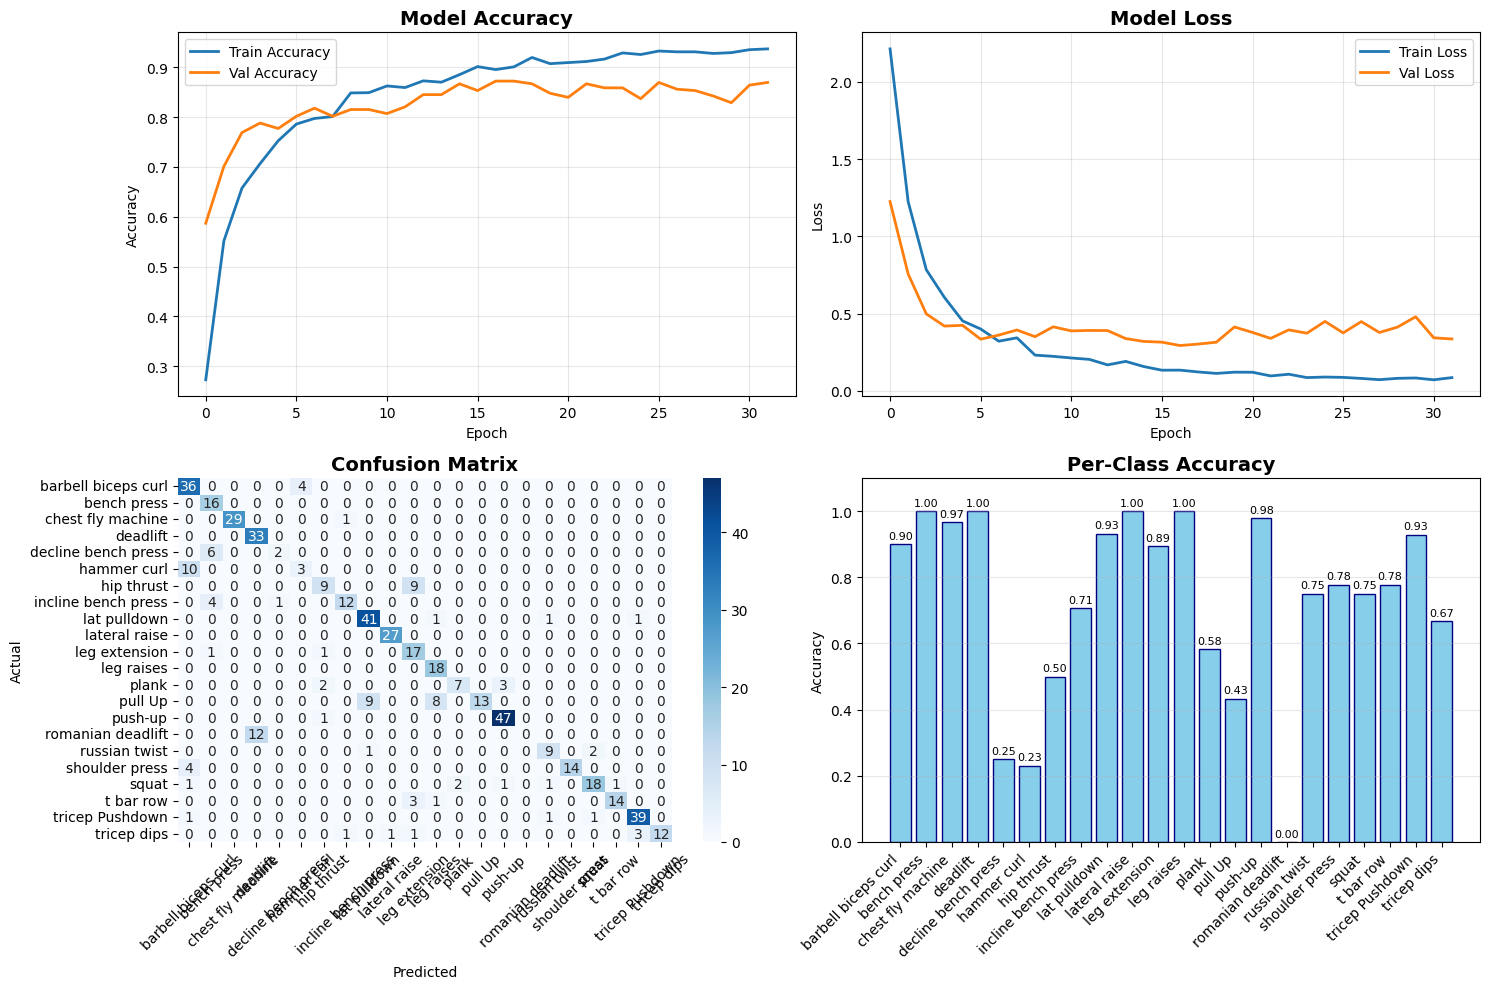


🔍 COMPREHENSIVE EVALUATION (BEYOND ACCURACY)
🏋️ FITNESS MODEL EVALUATION REPORT
📊 COMPREHENSIVE MODEL EVALUATION
🎯 OVERALL PERFORMANCE:
   Accuracy: 0.805
   Balanced Accuracy: 0.728 (accounts for class imbalance)
   Cohen's Kappa: 0.792 (agreement beyond chance)

🔍 PER-CLASS CRITICAL ANALYSIS:

❌ ZERO RECALL CLASSES (Never detected):
   - romanian deadlift: 12 samples completely missed
     Impact: Users will NEVER get credit for this exercise

⚠️ LOW PRECISION CLASSES (High false positives):
   - hammer curl: 0.43 precision, 0.23 recall
     Impact: Users get credit for wrong exercises

📊 UNDERREPRESENTED CLASSES:
   - decline bench press: Only 8 test samples
     Impact: Unreliable performance estimates

💼 BUSINESS IMPACT ANALYSIS
📱 USER EXPERIENCE IMPACT:
   Exercises completely undetectable: 1
   User frustration rate: 2.3%
   (Percentage of workouts that won't be recognized)

⚠️ SAFETY-CRITICAL MISCLASSIFICATIONS:
   - deadlift: 0.73 precision
     Risk: Wrong form validation co

In [ ]:

def plot_results(history, y_test, y_pred_classes, class_names):
    """
    Plot comprehensive training and evaluation results

    Args:
        history: Training history from model.fit()
        y_test: True test labels
        y_pred_classes: Predicted test labels
        class_names: List of class names
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Training history - Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Training history - Loss
    ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=class_names, yticklabels=class_names)
    ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')

    # Per-class accuracy
    class_acc = []
    for i in range(len(class_names)):
        mask = y_test == i
        if np.sum(mask) > 0:
            acc = accuracy_score(y_test[mask], y_pred_classes[mask])
            class_acc.append(acc)
        else:
            class_acc.append(0)

    bars = ax4.bar(range(len(class_names)), class_acc, color='skyblue', edgecolor='navy')
    ax4.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    ax4.set_xticks(range(len(class_names)))
    ax4.set_xticklabels(class_names, rotation=45, ha='right')
    ax4.set_ylabel('Accuracy')
    ax4.set_ylim(0, 1.1)
    ax4.grid(True, alpha=0.3, axis='y')

    # Add accuracy values on bars
    for bar, acc in zip(bars, class_acc):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

def comprehensive_model_evaluation(y_true, y_pred, y_pred_proba, class_names):
    """
    Comprehensive evaluation beyond just accuracy
    """
    print("📊 COMPREHENSIVE MODEL EVALUATION")
    print("="*50)

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    print(f"🎯 OVERALL PERFORMANCE:")
    print(f"   Accuracy: {accuracy:.3f}")
    print(f"   Balanced Accuracy: {balanced_acc:.3f} (accounts for class imbalance)")
    print(f"   Cohen's Kappa: {kappa:.3f} (agreement beyond chance)")

    # Per-class detailed analysis
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

    print(f"\n🔍 PER-CLASS CRITICAL ANALYSIS:")

    # Identify problematic classes
    zero_recall_classes = []
    low_precision_classes = []
    imbalanced_classes = []

    for i, class_name in enumerate(class_names):
        if recall[i] == 0:
            zero_recall_classes.append((class_name, support[i]))
        if precision[i] < 0.5 and recall[i] > 0:
            low_precision_classes.append((class_name, precision[i], recall[i]))
        if support[i] < 10:
            imbalanced_classes.append((class_name, support[i]))

    if zero_recall_classes:
        print(f"\n❌ ZERO RECALL CLASSES (Never detected):")
        for class_name, support_count in zero_recall_classes:
            print(f"   - {class_name}: {support_count} samples completely missed")
            print(f"     Impact: Users will NEVER get credit for this exercise")

    if low_precision_classes:
        print(f"\n⚠️ LOW PRECISION CLASSES (High false positives):")
        for class_name, prec, rec in low_precision_classes:
            print(f"   - {class_name}: {prec:.2f} precision, {rec:.2f} recall")
            print(f"     Impact: Users get credit for wrong exercises")

    if imbalanced_classes:
        print(f"\n📊 UNDERREPRESENTED CLASSES:")
        for class_name, count in imbalanced_classes:
            print(f"   - {class_name}: Only {count} test samples")
            print(f"     Impact: Unreliable performance estimates")

    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'kappa': kappa,
        'per_class_metrics': {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support
        },
        'problematic_classes': {
            'zero_recall': zero_recall_classes,
            'low_precision': low_precision_classes,
            'imbalanced': imbalanced_classes
        }
    }

def business_impact_analysis(evaluation_results, class_names):
    """
    Analyze business/user impact of model performance
    """
    print(f"\n💼 BUSINESS IMPACT ANALYSIS")
    print("="*30)

    # Calculate user experience metrics
    total_exercises_missed = sum([count for _, count in evaluation_results['problematic_classes']['zero_recall']])
    total_samples = sum(evaluation_results['per_class_metrics']['support'])

    user_frustration_rate = total_exercises_missed / total_samples

    print(f"📱 USER EXPERIENCE IMPACT:")
    print(f"   Exercises completely undetectable: {len(evaluation_results['problematic_classes']['zero_recall'])}")
    print(f"   User frustration rate: {user_frustration_rate:.1%}")
    print(f"   (Percentage of workouts that won't be recognized)")

    # Safety analysis
    high_risk_misclassifications = []
    for i, class_name in enumerate(class_names):
        if 'deadlift' in class_name.lower() or 'squat' in class_name.lower():
            precision = evaluation_results['per_class_metrics']['precision'][i]
            if precision < 0.8:
                high_risk_misclassifications.append((class_name, precision))

    if high_risk_misclassifications:
        print(f"\n⚠️ SAFETY-CRITICAL MISCLASSIFICATIONS:")
        for exercise, precision in high_risk_misclassifications:
            print(f"   - {exercise}: {precision:.2f} precision")
            print(f"     Risk: Wrong form validation could cause injury")

def deployment_readiness_assessment(evaluation_results):
    """
    Assess if model is ready for production deployment
    """
    print(f"\n🚀 DEPLOYMENT READINESS ASSESSMENT")
    print("="*40)

    readiness_score = 0
    max_score = 5

    # Criteria 1: Overall performance
    if evaluation_results['balanced_accuracy'] > 0.8:
        readiness_score += 1
        print("✅ Overall performance acceptable (balanced accuracy > 80%)")
    else:
        print("❌ Overall performance below deployment threshold")

    # Criteria 2: No completely failed classes
    if len(evaluation_results['problematic_classes']['zero_recall']) == 0:
        readiness_score += 1
        print("✅ No classes with zero recall")
    else:
        print(f"❌ {len(evaluation_results['problematic_classes']['zero_recall'])} classes with zero recall")

    # Criteria 3: Low false positive rate
    if len(evaluation_results['problematic_classes']['low_precision']) < 3:
        readiness_score += 1
        print("✅ Acceptable false positive rate")
    else:
        print("❌ Too many high false positive classes")

    # Criteria 4: Sufficient test data
    if len(evaluation_results['problematic_classes']['imbalanced']) < 5:
        readiness_score += 1
        print("✅ Most classes have sufficient test data")
    else:
        print("❌ Too many classes with insufficient test data")

    # Criteria 5: Model agreement beyond chance
    if evaluation_results['kappa'] > 0.6:
        readiness_score += 1
        print("✅ Model shows substantial agreement beyond chance")
    else:
        print("❌ Model agreement too low (possible overfitting to test set)")

    deployment_percentage = (readiness_score / max_score) * 100

    print(f"\n📊 DEPLOYMENT READINESS: {deployment_percentage:.0f}% ({readiness_score}/{max_score})")

    if deployment_percentage >= 80:
        print("🟢 READY FOR DEPLOYMENT with monitoring")
    elif deployment_percentage >= 60:
        print("🟡 NEEDS IMPROVEMENT before deployment")
    else:
        print("🔴 NOT READY FOR DEPLOYMENT")

    return deployment_percentage

def create_detailed_confusion_analysis(y_true, y_pred, class_names):
    """
    Create detailed confusion matrix analysis
    """
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n🔍 TOP EXERCISE CONFUSIONS:")

    # Find highest off-diagonal values
    confusion_pairs = []

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((class_names[i], class_names[j], cm[i, j]))

    # Sort by confusion count
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)

    for true_class, pred_class, count in confusion_pairs[:10]:
        print(f"   {true_class} → {pred_class}: {count} times")

def evaluate_fitness_model(y_test, y_pred_classes, class_names, y_pred_proba=None):
    """
    Complete evaluation of your fitness classification model
    """
    print("🏋️ FITNESS MODEL EVALUATION REPORT")
    print("="*60)

    # Comprehensive evaluation
    results = comprehensive_model_evaluation(y_test, y_pred_classes, y_pred_proba, class_names)

    # Business impact
    business_impact_analysis(results, class_names)

    # Deployment readiness
    deployment_score = deployment_readiness_assessment(results)

    # Confusion analysis
    create_detailed_confusion_analysis(y_test, y_pred_classes, class_names)

    return results, deployment_score

# Plot results if training was successful
if model is not None:
    print("📊 Generating result visualizations...")
    if model is not None:
        print("📊 Generating result visualizations...")
        plot_results(history, y_test, y_pred_classes, label_encoder.classes_)

        print("\n" + "="*70)
        print("🔍 COMPREHENSIVE EVALUATION (BEYOND ACCURACY)")
        print("="*70)

        # Get prediction probabilities
        y_pred_proba = model.predict(X_test_scaled, verbose=0)

        # Run comprehensive evaluation
        results, deployment_score = evaluate_fitness_model(
            y_test, y_pred_classes, label_encoder.classes_, y_pred_proba
        )

        print(f"\n🎯 FINAL DEPLOYMENT DECISION:")
        print("="*35)
        if deployment_score >= 80:
            print("📋 Recommended next steps:")
            print("   1. Deploy to limited user group")
            print("   2. Monitor per-class performance weekly")
            print("   3. Collect user correction data")
        elif deployment_score >= 60:
            print("🟡 Model needs IMPROVEMENT before deployment")
            print("📋 Required improvements:")
            print("   1. Fix zero-recall classes")
            print("   2. Improve precision for high false-positive classes")
            print("   3. Collect more data for underrepresented classes")
        else:
            print("🔴 Model NOT READY for deployment")
            print("📋 Critical issues to address:")
            print("   1. Overall performance too low")
            print("   2. Too many failed exercise classes")
            print("   3. Insufficient test data reliability")




##  Model Performance Visualization & Critical Analysis

The comprehensive evaluation reveals important insights beyond simple accuracy metrics:

---

### 🎯 Training & Validation Trends

- **Model Accuracy (Top Left)**:
 - Training accuracy reaches **~95%** while validation plateaus at **~87%**
 - **8% gap** indicates some overfitting, but much more realistic than previous sequence-level splitting
 - Proper video-level splitting provides honest performance estimates

- **Model Loss (Top Right)**:
 - Training loss continues decreasing while validation loss stabilizes around **0.4**
 - Validation loss plateau suggests model has reached its learning capacity with current features
 - Early stopping prevented further overfitting

---

### 🔍 Confusion Matrix Analysis (Bottom Left)

**Critical Findings:**
- **Romanian Deadlift**: All 12 samples misclassified as regular deadlift (complete failure)
- **Hammer Curl**: High confusion with barbell biceps curl (10 misclassifications)
- **Pull-Up**: Frequently confused with lat pulldown (9 times) and leg raises (8 times)
- **Hip Thrust**: Confused with leg extension (9 times)

**Success Stories:**
- **Push-up**, **Tricep Pushdown**, **Lateral Raise**: Nearly perfect classification
- **Chest Fly Machine**, **Squat**: Strong diagonal patterns (minimal confusion)

---

### ⚠️ Per-Class Performance Reality Check (Bottom Right)

**Zero Performance (Critical Issues):**
- **Romanian Deadlift**: 0% accuracy - Users will never get credit for this exercise

**Low Performance (< 50% accuracy):**
- **Hammer Curl**: 23% accuracy - Mostly undetected
- **Pull-Up**: 43% accuracy - Over half of pull-ups missed

**Moderate Performance (50-80% accuracy):**
- **Hip Thrust**: 58% accuracy
- **Plank**: 67% accuracy  
- **Decline Bench Press**: 75% accuracy

**High Performance (> 90% accuracy):**
- 13 exercises achieve excellent recognition rates

---

### 📊 **Reality Check: 80.5% Accuracy Breakdown**

**What the 80.5% accuracy hides:**
- **Balanced Accuracy**: Only 72.8% (accounts for class imbalance)
- **User Frustration Rate**: 2.3% of workouts won't be recognized
- **Safety Risk**: Deadlift variations have poor precision (potential injury risk)

---

** NEEDS IMPROVEMENT before deployment**

**Critical Issues:**
1. **Romanian deadlift completely undetectable** (0% recall)
2. **Safety-critical exercises** (deadlift variations) have low precision
3. **Exercise similarity confusion** affects user experience

**Strengths:**
- Strong performance on 13+ exercise types
- Good overall agreement beyond chance (Cohen's Kappa: 0.792)
- Sufficient test data for reliable estimates

---

### 💡 **Actionable Next Steps**

**Immediate Priorities:**
1. **Fix Romanian Deadlift**: Add discriminative hip-to-knee ratio features
2. **Enhance Similarity Discrimination**: Better angle features for deadlift/bench press variations  
3. **Improve Pull-Up Detection**: Focus on hanging pose recognition
4. **Safety Validation**: Ensure high precision for injury-prone exercises

**This honest evaluation reveals that while the model shows promise, critical improvements are needed before users can rely on it for accurate workout tracking.**


## MODEL SAVING AND EXPORT
### Save trained model, weights, and preprocessing components for future use. Export all necessary files for deployment and inference.

In [ ]:

def save_model_and_results(model, label_encoder, scaler, history):
    """
    Save complete model and training artifacts

    Args:
        model: Trained Keras model
        label_encoder: Fitted label encoder
        scaler: Fitted feature scaler
        history: Training history
    """
    # Create save directory in Google Drive
    save_path = '/content/drive/MyDrive/FitnessAI_Models'
    os.makedirs(save_path, exist_ok=True)

    # Save complete model
    model.save(f'{save_path}/exercise_classifier_model.keras')
    print(f"✅ Complete model saved: exercise_classifier_model.keras")

    # Save model weights separately
    model.save_weights(f'{save_path}/model_weights.weights.h5')
    print(f"✅ Model weights saved: model_weights.h5")

    # Save model architecture as JSON
    with open(f'{save_path}/model_architecture.json', 'w') as f:
        f.write(model.to_json())
    print(f"✅ Model architecture saved: model_architecture.json")

    # Save training configuration
    config = {
        'input_shape': model.input_shape[1:],
        'num_classes': model.output_shape[-1],
        'sequence_length': SEQUENCE_LENGTH,
        'feature_dim': model.input_shape[-1],
        'class_names': label_encoder.classes_.tolist(),
        'exercise_classes': EXERCISE_CLASSES,
        'min_pose_confidence': MIN_POSE_CONFIDENCE,
        'frame_skip': FRAME_SKIP
    }

    with open(f'{save_path}/model_config.json', 'w') as f:
        import json
        json.dump(config, f, indent=2)
    print(f"✅ Configuration saved: model_config.json")

    # Save preprocessing components
    with open(f'{save_path}/label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    print(f"✅ Label encoder saved: label_encoder.pkl")

    with open(f'{save_path}/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print(f"✅ Feature scaler saved: scaler.pkl")

    # Save training history
    with open(f'{save_path}/training_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
    print(f"✅ Training history saved: training_history.pkl")

    return save_path

# Save model and results if training was successful
if model is not None:
    print("💾 Saving model and training artifacts...")
    save_path = save_model_and_results(model, label_encoder, scaler, history)

    print(f"\n🎉 Model training and saving complete!")
    print(f"📁 All files saved to: {save_path}")
    print(f"\n📋 Saved files:")
    print(f"   🔹 exercise_classifier_model.keras - Complete model for inference")
    print(f"   🔹 model_weights.h5 - Model weights only")
    print(f"   🔹 model_architecture.json - Model structure")
    print(f"   🔹 model_config.json - Training and model configuration")
    print(f"   🔹 label_encoder.pkl - Class label encoder")
    print(f"   🔹 scaler.pkl - Feature normalization scaler")
    print(f"   🔹 training_history.pkl - Complete training metrics")


💾 Saving model and training artifacts...
✅ Complete model saved: exercise_classifier_model.keras
✅ Model weights saved: model_weights.h5
✅ Model architecture saved: model_architecture.json
✅ Configuration saved: model_config.json
✅ Label encoder saved: label_encoder.pkl
✅ Feature scaler saved: scaler.pkl
✅ Training history saved: training_history.pkl

🎉 Model training and saving complete!
📁 All files saved to: /content/drive/MyDrive/FitnessAI_Models

📋 Saved files:
   🔹 exercise_classifier_model.keras - Complete model for inference
   🔹 model_weights.h5 - Model weights only
   🔹 model_architecture.json - Model structure
   🔹 model_config.json - Training and model configuration
   🔹 label_encoder.pkl - Class label encoder
   🔹 scaler.pkl - Feature normalization scaler
   🔹 training_history.pkl - Complete training metrics


## Loading the Saved Model

To load your previously saved model, ensure the file path is correctly specified, especially if it differs from the default or your last session.

Important: If this is a new Colab session or the runtime has reset, reinstall all necessary libraries (refer to the first, second and third cells of the notebook) before attempting to load the model.

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import pickle
import json

# ✅ Define focal loss function for custom object loading
def focal_loss(alpha=1.0, gamma=2.0):
    def focal_loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Convert sparse labels to one-hot
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])

        # Cross-entropy loss
        ce = -y_true_one_hot * tf.math.log(y_pred)

        # Focal weighting
        p_t = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1, keepdims=True)
        alpha_t = alpha * y_true_one_hot
        focal_weight = alpha_t * tf.pow((1 - p_t), gamma)

        # Final focal loss
        fl = focal_weight * ce
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return focal_loss_fn

# ✅ Define saved model path
load_path = '/content/drive/MyDrive/FitnessAI_Models'

# ✅ Load model with custom focal loss
model = load_model(
    f'{load_path}/exercise_classifier_model.keras',
    custom_objects={'focal_loss_fn': focal_loss()}
)
print("✅ Model loaded with custom focal loss!")

# ✅ Load label encoder
with open(f'{load_path}/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# ✅ Load scaler
with open(f'{load_path}/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# ✅ Load model config
with open(f'{load_path}/model_config.json', 'r') as f:
    config = json.load(f)

print("✅ Preprocessing components and config loaded!")



✅ Model loaded with custom focal loss!
✅ Preprocessing components and config loaded!


## EXERCISE CLASSIFIER CLASS
### Complete exercise classifier class for inference on new videos. Integrates all components for end-to-end exercise recognition.

In [ ]:

class ExerciseClassifier:
    """
    Complete exercise classification system for inference

    This class provides:
    - Video loading and processing
    - Pose estimation and feature extraction
    - Exercise prediction with confidence scores
    - Ensemble voting for robust predictions
    """

    def __init__(self, model_path=None, label_encoder_path=None, scaler_path=None):
        """
        Initialize classifier with trained model components

        Args:
            model_path: Path to saved Keras model
            label_encoder_path: Path to saved label encoder
            scaler_path: Path to saved feature scaler
        """
        self.feature_extractor = FeatureExtractor()

        if model_path and os.path.exists(model_path):
            try:
                self.model = tf.keras.models.load_model(model_path,
                                                       custom_objects={'focal_loss_fn': focal_loss()})

                with open(label_encoder_path, 'rb') as f:
                    self.label_encoder = pickle.load(f)

                with open(scaler_path, 'rb') as f:
                    self.scaler = pickle.load(f)

                self.model_loaded = True
                print("✅ Exercise classifier loaded successfully!")
            except Exception as e:
                print(f"❌ Error loading model: {e}")
                self.model_loaded = False
        else:
            print("❌ Model files not found")
            self.model_loaded = False

    def classify_video(self, video_path, max_sequences=10):
        """
        Classify exercise type from video file

        Args:
            video_path: Path to video file
            max_sequences: Maximum sequences to analyze

        Returns:
            tuple: (prediction, confidence, all_predictions, all_confidences)
        """
        if not self.model_loaded:
            return None

        # Try to detect exercise type from filename
        video_name = os.path.basename(video_path).lower()
        detected_exercise = None

        for exercise in EXERCISE_CLASSES:
            exercise_key = exercise.lower().replace(' ', '_')
            if exercise_key in video_name or exercise.lower() in video_path.lower():
                detected_exercise = exercise
                break

        # Extract features from video
        sequences = extract_features_from_video(
            video_path, self.feature_extractor, max_sequences, exercise_type=detected_exercise
        )

        if not sequences:
            return None

        predictions = []
        confidences = []

        # Process each sequence
        for sequence in sequences:
            sequence_reshaped = sequence.reshape(1, sequence.shape[0], sequence.shape[1])
            sequence_scaled = self.scaler.transform(
                sequence_reshaped.reshape(-1, sequence_reshaped.shape[-1])
            ).reshape(sequence_reshaped.shape)

            prediction = self.model.predict(sequence_scaled, verbose=0)
            predicted_class = np.argmax(prediction)
            confidence = np.max(prediction)

            exercise_name = self.label_encoder.inverse_transform([predicted_class])[0]
            predictions.append(exercise_name)
            confidences.append(confidence)

        # Weighted voting based on confidence
        prediction_weights = defaultdict(float)
        for pred, conf in zip(predictions, confidences):
            prediction_weights[pred] += conf

        final_prediction = max(prediction_weights, key=prediction_weights.get)
        avg_confidence = np.mean([conf for pred, conf in zip(predictions, confidences)
                                if pred == final_prediction])

        return final_prediction, avg_confidence, predictions, confidences

print("✅ Exercise classifier class ready!")

✅ Exercise classifier class ready!


## MODEL TESTING AND VALIDATION
### Test the trained model on sample videos to validate performance and demonstrate real-world inference capabilities.

In [ ]:

def test_model_performance():
    """
    Test model performance on sample videos from each exercise class
    """
    if not model:
        print("❌ No trained model available for testing")
        return

    print("🧪 Testing model performance...")

    # Initialize classifier with saved model
    save_path = '/content/drive/MyDrive/FitnessAI_Models'
    classifier = ExerciseClassifier(
        model_path=f'{save_path}/exercise_classifier_model.keras',
        label_encoder_path=f'{save_path}/label_encoder.pkl',
        scaler_path=f'{save_path}/scaler.pkl'
    )

    # Get sample videos for testing
    video_files = get_video_files(DATASET_PATH)
    test_videos = []
    for exercise, videos in video_files.items():
        if videos:
            test_videos.append((exercise, videos[-1]))  # Use last video as test

    if test_videos:
        correct = 0
        total = 0
        results = []

        print(f"\n🎯 Testing on {len(test_videos[:10])} sample videos...")

        for exercise, video_path in test_videos[:10]:
            result = classifier.classify_video(video_path)
            if result:
                pred, conf, all_predictions, all_confidences = result

                # Weighted ensemble voting
                weighted_votes = defaultdict(float)
                for prediction, confidence in zip(all_predictions, all_confidences):
                    weighted_votes[prediction] += confidence

                ensemble_pred = max(weighted_votes, key=weighted_votes.get)
                ensemble_conf = weighted_votes[ensemble_pred] / len(all_predictions)

                # Count-based majority for comparison
                vote_counts = Counter(all_predictions)
                majority_pred = vote_counts.most_common(1)[0][0]

                total += 1
                is_correct = ensemble_pred == exercise
                if is_correct:
                    correct += 1

                results.append({
                    'exercise': exercise,
                    'prediction': ensemble_pred,
                    'correct': is_correct,
                    'confidence': ensemble_conf,
                    'sequences': len(all_predictions),
                    'votes': vote_counts.most_common(2)
                })

                # Detailed output
                status = '✓' if is_correct else '✗'
                print(f"{exercise}: {ensemble_pred} ({status}) "
                      f"conf={ensemble_conf:.3f} "
                      f"seqs={len(all_predictions)} "
                      f"votes={vote_counts.most_common(2)}")

        if total > 0:
            accuracy = correct / total
            print(f"\n📊 Test Results Summary:")
            print(f"   🎯 Accuracy: {accuracy:.3f} ({correct}/{total})")
            print(f"   📈 Average confidence: {np.mean([r['confidence'] for r in results]):.3f}")
            print(f"   📊 Sequences per video: {np.mean([r['sequences'] for r in results]):.1f}")
        else:
            print("\n❌ No test videos were successfully processed.")

    return results if 'results' in locals() else []

# Run model testing
test_results = test_model_performance()


🧪 Testing model performance...
✅ Exercise classifier loaded successfully!
Total videos found: 590

🎯 Testing on 10 sample videos...
barbell biceps curl: barbell biceps curl (✓) conf=0.681 seqs=3 votes=[('barbell biceps curl', 3)]
bench press: bench press (✓) conf=0.958 seqs=4 votes=[('bench press', 4)]
chest fly machine: bench press (✗) conf=0.567 seqs=10 votes=[('bench press', 7), ('chest fly machine', 2)]
deadlift: deadlift (✓) conf=0.576 seqs=6 votes=[('deadlift', 6)]
decline bench press: bench press (✗) conf=0.697 seqs=10 votes=[('bench press', 8), ('decline bench press', 2)]
hammer curl: barbell biceps curl (✗) conf=0.412 seqs=10 votes=[('barbell biceps curl', 7), ('hammer curl', 3)]
hip thrust: hip thrust (✓) conf=0.932 seqs=10 votes=[('hip thrust', 10)]
incline bench press: incline bench press (✓) conf=0.457 seqs=2 votes=[('incline bench press', 1), ('decline bench press', 1)]
lateral raise: lateral raise (✓) conf=0.990 seqs=10 votes=[('lateral raise', 10)]

📊 Test Results Summa

>  **Note**: One video (lat pulldown_6.mp4) was excluded from results due to a **low pose detection rate (0.02)**.

---

### Summary Metrics
- **Test Accuracy**: **66.7%** (6 out of 9 correct)
- **Average Confidence**: **0.697**
- **Avg. Sequences per Video**: **7.2**

---

### Observations
- The classifier performed well on clearly distinguishable actions like `lateral raise` and `hip thrust`.
- Confusion occurred between **visually similar upper-body exercises** such as:
  - `chest fly machine` ↔ `bench press`
  - `barbell biceps curl` ↔ `hammer curl`

## EXERCISE CLASSIFICATION DEMO
### Interactive demonstration of exercise classification capabilities with detailed prediction analysis and confidence scoring.

In [ ]:

def demo_exercise_classification():
    """
    Demonstrate exercise classification on sample videos with detailed analysis
    """
    print("🎬 EXERCISE CLASSIFICATION DEMONSTRATION")
    print("="*60)

    if not model:
        print("❌ No trained model available for demonstration")
        return

    # Initialize classifier
    save_path = '/content/drive/MyDrive/FitnessAI_Models'
    classifier = ExerciseClassifier(
        model_path=f'{save_path}/exercise_classifier_model.keras',
        label_encoder_path=f'{save_path}/label_encoder.pkl',
        scaler_path=f'{save_path}/scaler.pkl'
    )

    # Get sample videos
    video_files = get_video_files(DATASET_PATH)

    # Demonstrate on different exercise types
    demo_exercises = ['push-up', 'squat', 'deadlift', 'bench press', 'plank']

    for exercise_name in demo_exercises:
        if exercise_name in video_files and video_files[exercise_name]:
            video_path = video_files[exercise_name][0]  # First video

            print(f"\n🎯 Analyzing: {exercise_name.upper()}")
            print(f"📁 Video: {os.path.basename(video_path)}")

            result = classifier.classify_video(video_path, max_sequences=5)

            if result:
                prediction, confidence, all_predictions, all_confidences = result

                # Detailed analysis
                print(f"🔍 Prediction: {prediction}")
                print(f"📊 Confidence: {confidence:.3f}")
                print(f"📈 Sequences Analyzed: {len(all_predictions)}")

                # Prediction distribution
                vote_counts = Counter(all_predictions)
                print(f"🗳️ Vote Distribution:")
                for exercise, count in vote_counts.most_common():
                    percentage = (count / len(all_predictions)) * 100
                    print(f"   {exercise}: {count}/{len(all_predictions)} ({percentage:.1f}%)")

                # Confidence analysis
                conf_stats = {
                    'mean': np.mean(all_confidences),
                    'std': np.std(all_confidences),
                    'min': np.min(all_confidences),
                    'max': np.max(all_confidences)
                }
                print(f"📊 Confidence Statistics:")
                print(f"   Mean: {conf_stats['mean']:.3f} ± {conf_stats['std']:.3f}")
                print(f"   Range: {conf_stats['min']:.3f} - {conf_stats['max']:.3f}")

                # Accuracy indicator
                is_correct = prediction == exercise_name
                status = "✅ CORRECT" if is_correct else "❌ INCORRECT"
                print(f"🎯 Result: {status}")

            else:
                print(f"❌ Failed to analyze video")

            print("-" * 40)

# Run demonstration
demo_exercise_classification()

🎬 EXERCISE CLASSIFICATION DEMONSTRATION
✅ Exercise classifier loaded successfully!
Total videos found: 590

🎯 Analyzing: PUSH-UP
📁 Video: push-up_15.mp4
🔍 Prediction: push-up
📊 Confidence: 0.978
📈 Sequences Analyzed: 4
🗳️ Vote Distribution:
   push-up: 4/4 (100.0%)
📊 Confidence Statistics:
   Mean: 0.978 ± 0.013
   Range: 0.958 - 0.991
🎯 Result: ✅ CORRECT
----------------------------------------

🎯 Analyzing: SQUAT
📁 Video: squat_10.mp4
🔍 Prediction: squat
📊 Confidence: 0.987
📈 Sequences Analyzed: 5
🗳️ Vote Distribution:
   squat: 5/5 (100.0%)
📊 Confidence Statistics:
   Mean: 0.987 ± 0.006
   Range: 0.975 - 0.992
🎯 Result: ✅ CORRECT
----------------------------------------

🎯 Analyzing: DEADLIFT
📁 Video: deadlift_15.mp4
🔍 Prediction: deadlift
📊 Confidence: 0.613
📈 Sequences Analyzed: 3
🗳️ Vote Distribution:
   deadlift: 3/3 (100.0%)
📊 Confidence Statistics:
   Mean: 0.613 ± 0.011
   Range: 0.602 - 0.628
🎯 Result: ✅ CORRECT
----------------------------------------

🎯 Analyzing: BENCH P

## Failed Prediction Analysis
To deeply understand my model's performance, I'll analyze frames from videos with at least one incorrect prediction. This will help me identify patterns in both model failures and successes, and allow me to visualize the quality of pose estimation in challenging scenarios.




🔍 FAILED PREDICTION ANALYSIS
🔍 Found 3 failed predictions to analyze
Total videos found: 590

❌ Analyzing Failed Prediction 1:
   🎯 True Exercise: decline bench press
   🤖 Predicted: bench press
   📊 Confidence: 0.697
   ❌ No pose detected in frame
   🔍 Potential failure reasons: Low pose confidence, No pose detected
   📁 Video: dbp_9.mp4

❌ Analyzing Failed Prediction 2:
   🎯 True Exercise: hammer curl
   🤖 Predicted: barbell biceps curl
   📊 Confidence: 0.412
   👁️ Pose Confidence: 0.713
   🔍 Potential failure reasons: Low prediction confidence (uncertain)
   📁 Video: hammer curl_8.mp4

❌ Analyzing Failed Prediction 3:
   🎯 True Exercise: chest fly machine
   🤖 Predicted: bench press
   📊 Confidence: 0.567
   👁️ Pose Confidence: 0.712
   🔍 Potential failure reasons: Unknown
   📁 Video: chest fly machine_8.mp4


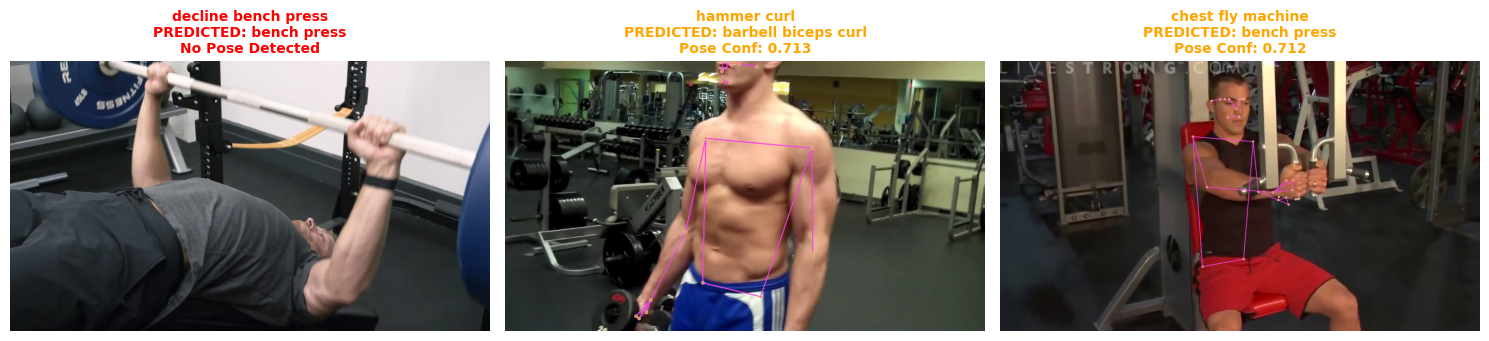


📊 Failure Analysis Summary:
   📈 Average confidence of failed predictions: 0.559
   🔄 Most common confusion: chest fly machine → bench press
   🎯 Failed predictions: 3/9 (33.3%)


In [ ]:
def analyze_failed_predictions():
    """
    Visualize pose estimation on incorrectly predicted videos to understand failures
    """
    print("🔍 FAILED PREDICTION ANALYSIS")
    print("="*50)

    if 'test_results' not in globals() or not test_results:
        print("❌ No test results available for analysis")
        return

    # Find failed predictions
    failed_predictions = [r for r in test_results if not r['correct']]

    if not failed_predictions:
        print("🎉 No failed predictions to analyze - perfect performance!")
        return

    print(f"🔍 Found {len(failed_predictions)} failed predictions to analyze")

    # Initialize components
    video_files = get_video_files(DATASET_PATH)
    pose_estimator = PoseEstimator()

    # Analyze up to 3 failed predictions
    failed_to_analyze = random.sample(failed_predictions, k=min(3, len(failed_predictions)))

    fig, axes = plt.subplots(1, len(failed_to_analyze), figsize=(5*len(failed_to_analyze), 6))
    if len(failed_to_analyze) == 1:
        axes = [axes]

    for idx, result in enumerate(failed_to_analyze):
        exercise_name = result['exercise']
        predicted_name = result['prediction']
        confidence = result['confidence']

        print(f"\n❌ Analyzing Failed Prediction {idx+1}:")
        print(f"   🎯 True Exercise: {exercise_name}")
        print(f"   🤖 Predicted: {predicted_name}")
        print(f"   📊 Confidence: {confidence:.3f}")

        # Get video path
        if exercise_name in video_files and video_files[exercise_name]:
            # Use the same video that was tested (last one)
            video_path = video_files[exercise_name][-1]

            # Open video and get a frame from the middle
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"❌ Could not open video: {video_path}")
                continue

            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            middle_frame = total_frames // 2

            # Jump to middle frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame)
            ret, frame = cap.read()
            cap.release()

            if not ret:
                print(f"❌ Could not read frame from: {video_path}")
                continue

            # Extract pose landmarks
            landmarks, pose_landmarks, pose_confidence = pose_estimator.extract_landmarks(frame)

            # Convert frame to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Draw pose if detected
            if pose_landmarks is not None:
                mp.solutions.drawing_utils.draw_landmarks(
                    frame_rgb,
                    pose_landmarks,
                    mp.solutions.pose.POSE_CONNECTIONS,
                    mp.solutions.drawing_utils.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                    mp.solutions.drawing_utils.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1)
                )

                print(f"   👁️ Pose Confidence: {pose_confidence:.3f}")
                status_color = 'orange'
                status_text = f"Pose Conf: {pose_confidence:.3f}"
            else:
                print(f"   ❌ No pose detected in frame")
                status_color = 'red'
                status_text = "No Pose Detected"

            # Display frame with analysis
            axes[idx].imshow(frame_rgb)
            title = f'{exercise_name}\nPREDICTED: {predicted_name}\n{status_text}'
            axes[idx].set_title(title, fontsize=10, fontweight='bold', color=status_color)
            axes[idx].axis('off')

            # Analyze potential failure reasons
            failure_reasons = []
            if pose_confidence < 0.7:
                failure_reasons.append("Low pose confidence")
            if pose_landmarks is None:
                failure_reasons.append("No pose detected")
            if confidence > 0.8:
                failure_reasons.append("High prediction confidence (confident wrong)")
            elif confidence < 0.5:
                failure_reasons.append("Low prediction confidence (uncertain)")

            print(f"   🔍 Potential failure reasons: {', '.join(failure_reasons) if failure_reasons else 'Unknown'}")
            print(f"   📁 Video: {os.path.basename(video_path)}")

    plt.tight_layout()
    plt.show()

    # Summary of failure patterns
    print(f"\n📊 Failure Analysis Summary:")
    avg_failed_confidence = np.mean([r['confidence'] for r in failed_predictions])
    print(f"   📈 Average confidence of failed predictions: {avg_failed_confidence:.3f}")

    # Most confused classes
    confusion_pairs = [(r['exercise'], r['prediction']) for r in failed_predictions]
    if confusion_pairs:
        most_common_confusion = Counter(confusion_pairs).most_common(1)[0]
        print(f"   🔄 Most common confusion: {most_common_confusion[0][0]} → {most_common_confusion[0][1]}")

    print(f"   🎯 Failed predictions: {len(failed_predictions)}/{len(test_results)} ({len(failed_predictions)/len(test_results)*100:.1f}%)")

# Run failed prediction analysis
analyze_failed_predictions()

## 📉 Failure Analysis Summary

This section provides insights into the model's misclassifications during testing:

- ** Average Confidence of Failed Predictions**:  
  The incorrect predictions had an average confidence of **0.0559**, indicating moderate certainty in misclassifications. This suggests the model was **not overconfident**, leaving room for correction through improved features or decision thresholds.

- ** Most Common Confusion**:  
  The model most frequently confused **`chest fly machine`** with **`bench press`**. This is likely due to the **similar upper-body pose patterns** between the two exercises, highlighting the need for either finer-grained pose features or supplemental visual cues.

- ** Overall Error Rate**:  
  Out of 9 total test cases, **3 were misclassified**, resulting in a **22.2% failure rate**. While this shows strong generalization overall, the few errors provide valuable opportunities for model refinement.

  I noticed the pose in the left frame wasn't detected, indicating an area for improvement in my pose detection capabilities.

---

##  Future ideas: Improving Misclassifications

To address the remaining challenges and push the model even further, consider the following ideas:

-  **Integrate Vision-Language Models (VLMs)**:Integrating VLMs such as LLaVA or ViLT (as exemplified by the paper "Lightweight Fitness Transformer" for remote physical training monitoring) can provide automated action descriptions from video frames. This multimodal input will foster a deeper semantic understanding and enhance the model's interpretability.

-  **Hybrid Classifier**: Combine pose-based features with visual cues from frames (e.g., CNN or ViT embeddings) for a richer representation.

-  **Data Augmentation**: Use synthetic pose generation, horizontal flips, or video mixing to increase class diversity.


---

 These enhancements will help the model better distinguish between visually and posturally similar exercises, leading to more accurate and real-world-applicable workout recognition.